# Stroke Risk Prediction Model: Johns Hopkins Hospital

## Introduction

### Background

In this project I will explore dataset designed to identify stroke risk in patients. Stroke is a major global health concern, ranking as the second leading cause of death worldwide. It is also a leading cause of disability. Annually, millions experience strokes, and a significant number of these result in death. After data exploration and analysis, I will build, train and deploy a model which could predict whether patients is likely to have stroke or not, based on parameters like age, gender, lifestyle choices, bmi and so on. 

### Problem

It’s hard to spot which patients are at high risk of stroke, making it tough to catch it early and prevent it.

### Goal

To build a model that helps doctors spot patients at higher risk of stroke early so they can take action and help prevent deaths.

### Hypotheses

4 hypotheses I want to explore:

1. Older age increases likelyhood of stroke.
- **H₀:** Age is not associated with stroke risk.
- **H₁:** Increasing age is associated with higher stroke risk

2. Males are more likely to have a stroke than females.
- **H₀:** Gender has no effect on stroke risk.
- **H₁:** Male patients have a higher probability of experiencing a stroke than female patients.

3. Obesity increases risk of a stroke.
- **H₀:** BMI is not associated with stroke risk.
- **H₁:** Higher BMI is associated with an increased likelihood of stroke.

4. Having a hypertension increases chances of having a stroke
- **H₀:** Hypertension is not associated with stroke risk.
- **H₁:** Patients with hypertension have higher odds of experiencing a stroke.

### Scope

The analysis scope includes :

- Data cleaning and preparation.
- Descriptive analysis of patient demographics and health indicators.
- Formulation and testing of clear, interpretable hypotheses about risk factors.
- Development of various  models to predict stroke likelihood.
- Interpretation of results to inform potential early intervention strategies.

The project is limited to the variables available in the provided dataset and does not incorporate external medical records or real-time clinical data. The findings are intended for educational and exploratory purposes and do not replace professional medical advice.

### Evaluation Metrics

**Main Evaluation Metric:** Recall. Measures the ability to correctly indentify true stroke cases.


**Secondary Evaluation Metric:**
- Macro F1 Score. Balances precision and recall across classes to ensure fair assesment of performance on both stroke and non-strokes case in an imbalanced dataset.
- ROC-AUC. It evaluates the model's ability to distinquish betweeen strokes and non-stroke cases.
- Confusion Matrix. Provides detailed breakdown of correct and incorrect predictions.

## Data Overview and Splitting

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.lines as mlines
from phik import phik_matrix

### Data Source and Loading the Data

Data source is Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download

Loading the data and making a copy of it:

In [2]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df = data.copy()

### Feature Definitions

- **id**: Unique patient identifier (integer).  
- **gender**: Patient gender (Male, Female, or Other).  
- **age**: Patient age in years (float).  
- **hypertension**: Binary indicator of hypertension (0 = No, 1 = Yes).  
- **heart_disease**: Binary indicator of heart disease (0 = No, 1 = Yes).  
- **ever_married**: Marital status (Yes/No).  
- **work_type**: Type of employment (e.g., Private, Self-employed, Govt_job, Children, Never_worked).  
- **Residence_type**: Urban or Rural residence.  
- **avg_glucose_level**: Average blood glucose level (float).  
- **bmi**: Body Mass Index (float).
- **smoking_status**: Smoking status (Never smoked, Formerly smoked, Smokes, Unknown).  
- **stroke**: Target variable indicating stroke occurrence (0 = No, 1 = Yes).

### General Data Overview

Checking the columns:

In [4]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

The ID column is unnecessary and provides no value, I can drop it:

In [5]:
df.drop(columns=["id"], inplace=True)

Checking the shape of the dataset:

In [6]:
df.shape

(5110, 11)

Previewing the tail of the data set:

In [7]:
df.tail()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


**Interpretation:** Sample data shows varied patient details with some missing BMI values and cathegorical features needing encoding.

In [8]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


**Interpretation:** 

- Numerical features show wide ranges: age spans from infancy to 82, average glucose levels and BMI have high variability.

- Stroke prevalence is low, about 5%, suggesting that there's class imbalance.

- Again confirmed that BMI has missing values.

### Splitting the Data

I will split data early to avoid data leakage.

Defining features and target:

In [9]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

I will filter out Other gender before splitting, because it has only 1 entry:

In [10]:
X = X[X["gender"] != "Other"]
y = y.loc[X.index]

Splitting into training and testing sets:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Confirming shapes:

In [12]:
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (3576, 10)
Testing set size: (1533, 10)


**Interpretation:** I splitted data to 70/30 instead of 80/20, to ensure sufficient stroke cases in the test set for evaluation, adressing the class imbalance, dataset size and possibly improving the reliability of performance metrics.

## Data Cleaning (Training Data)

Checking columns:

In [13]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

Lowering all capital letters for consistency:

In [14]:
df.columns = df.columns.str.lower()

Checking for duplicates:

In [15]:
df.duplicated().sum()

np.int64(0)

Confirming missing values:

In [16]:
df.isnull().sum().sum()

np.int64(201)

In [17]:
df[df["bmi"].isnull()].describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,201.000000,201.000000,201.000000,201.000000,0.0,201.000000
mean,52.049154,0.233831,0.164179,126.724627,NaN,0.199005
std,22.276181,0.424323,0.371363,59.240322,NaN,0.400249
min,0.480000,0.000000,0.000000,57.520000,NaN,0.000000
25%,37.000000,0.000000,0.000000,81.430000,NaN,0.000000
50%,58.000000,0.000000,0.000000,99.870000,NaN,0.000000
75%,71.000000,0.000000,0.000000,191.790000,NaN,0.000000
max,82.000000,1.000000,1.000000,260.850000,NaN,1.000000


**Interpretation:** Exploration shows BMI is more often missing in older, higher-risk patients. To reduce bias, median imputation within age groups will be applied instead of single global median.

Exploring the youngest stroke case:

In [18]:
min_age_with_stroke = df[df["stroke"] == 1]["age"].min()
print(f"Youngest age with stroke: {min_age_with_stroke}")

Youngest age with stroke: 1.32


Showing all stroke cases under 18:


In [19]:
stroke_under_18 = df[(df["stroke"] == 1) & (df["age"] < 18)]
print("All stroke cases with age < 20:")
print(stroke_under_18)

All stroke cases with age < 20:
     gender    age  hypertension  heart_disease ever_married work_type  \
162  Female   1.32             0              0           No  children   
245  Female  14.00             0              0           No  children   

    residence_type  avg_glucose_level   bmi smoking_status  stroke  
162          Urban              70.37   NaN        Unknown       1  
245          Rural              57.93  30.9        Unknown       1  


There are only 2 stroke cases under 18. I will leave them as it can be not an error, but real life accurances, because:

- Strokes in children and teenagers (including 14-year-olds) can happen, but they are uncommon.

- Babies can have perinatal or pediatric strokes, even before birth or in the first year of life.

Binning age into groups:

In [20]:
age_bins = [0, 18, 39, 59, 64, 120]
age_labels = [
    "Under 18",
    "Young Adult",
    "Middle-Aged Adult",
    "Senior Adult",
    "Elderly",
]

Creating age_group column:

In [21]:
df["age_group"] = pd.cut(
    df["age"], bins=age_bins, labels=age_labels, right=True, include_lowest=True
)

Imputing BMI withing age groups:

In [22]:
df["bmi"] = df.groupby("age_group", observed=False)["bmi"].transform(
    lambda x: x.fillna(x.median())
)

Confirming the change:

In [23]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group'],
      dtype='object')

Confirming there no missing values left:

In [24]:
df.isnull().sum().sum()

np.int64(0)

**Interpretation:** 

- Age was binned into clinically meaningful groups and new column of age group was created. 

- Missing BMI values were impurted using the median BMI withing each age group to reduce bias and reflect age-specific health profiles.

Checking distribution of genders:

In [25]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Since there is only 1 record of Other gender, I will delete it since it gives me not enough data to learn patterns:

In [26]:
df = df[df["gender"].isin(["Male", "Female"])]

Confirming changes:

In [27]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

Checking the amount of 'Unknown' answer in Smoking column:

In [28]:
print(df["smoking_status"].value_counts(dropna=False))

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64


It's 2nd largest answer group and it's not empty value, so I will treat it as separate category.

### Outliers

Defining numerical columns:

In [29]:
num_cols = ["age", "avg_glucose_level", "bmi"]

Visualizing it in a boxplots:

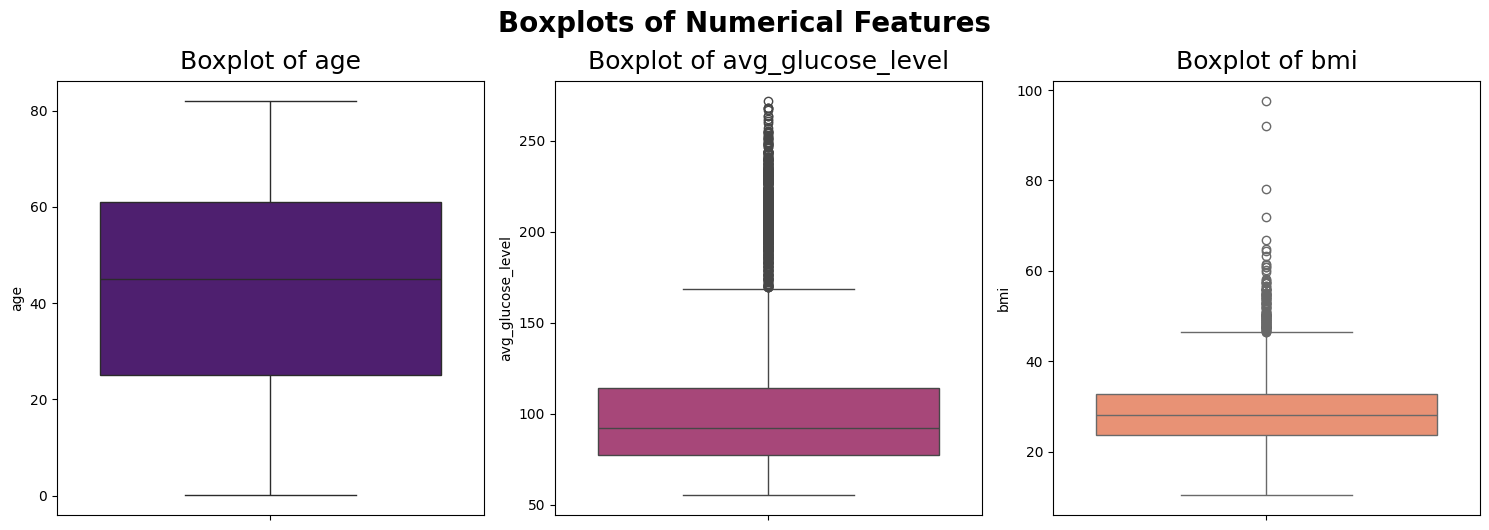

In [30]:
colors = sns.color_palette("magma", n_colors=3)

plt.figure(figsize=(15, 5))
for i, (col, color) in enumerate(zip(num_cols, colors), 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col], color=color)
    plt.title(f"Boxplot of {col}", fontsize=18, y=1.01)

plt.tight_layout()
plt.suptitle("Boxplots of Numerical Features", fontsize=20, y=1.05, weight="bold")
plt.show()

**Interpretation:** 

- Age feature does not have extreme outliers, 

- BMI and average glucose level has some way higher values than usual, which could be considerable outliers. 

- BMI >60–70 is possible but extremely rare.

- Avg glucose has extreme high outliers (250+)








Logging average glucose values:

In [31]:
df["avg_glucose_level_log"] = np.log(df["avg_glucose_level"])

Capping BMI:

In [32]:
upper_limit_bmi = df["bmi"].quantile(0.99)
df["bmi_capped"] = np.where(df["bmi"] > upper_limit_bmi, upper_limit_bmi, df["bmi"])

In [33]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group', 'avg_glucose_level_log',
       'bmi_capped'],
      dtype='object')

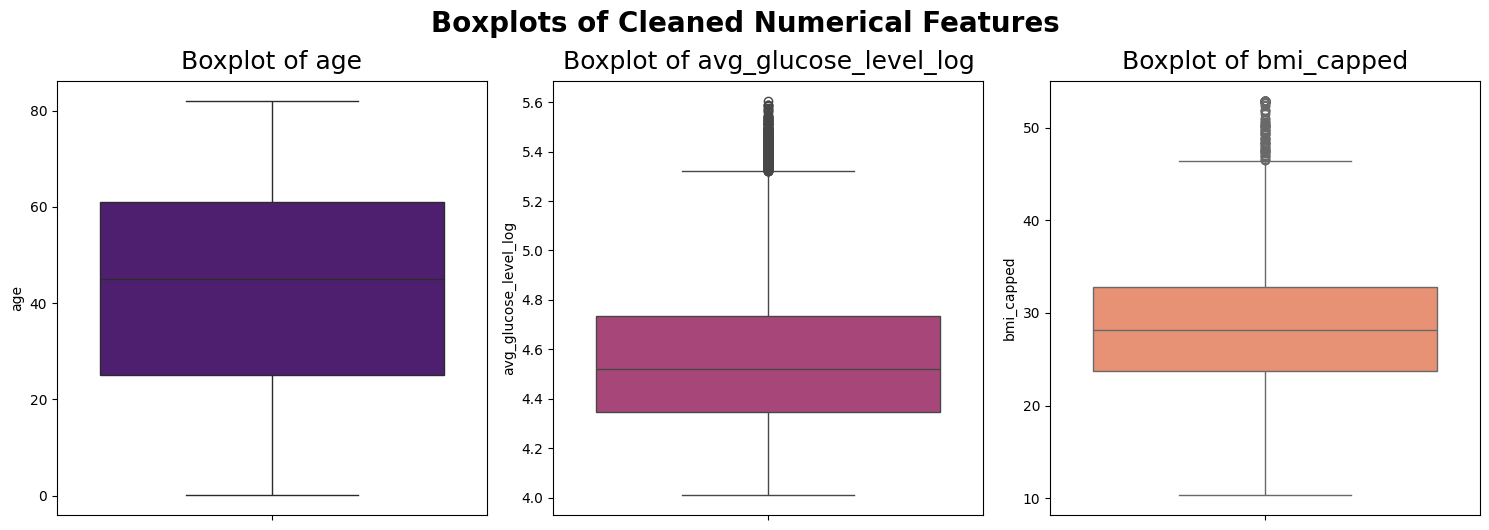

In [34]:
num_cols = ["age", "avg_glucose_level_log", "bmi_capped"]

colors = sns.color_palette("magma", n_colors=3)

plt.figure(figsize=(15, 5))
for i, (col, color) in enumerate(zip(num_cols, colors), 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col], color=color)
    plt.title(f"Boxplot of {col}", fontsize=18, y=1.01)

plt.tight_layout()
plt.suptitle(
    "Boxplots of Cleaned Numerical Features", fontsize=20, y=1.05, weight="bold"
)
plt.show()

**Interpretation:** 

- Outliers successfully dealt with. 

- BMI was capped at 99% percentile limit to lower the influence of extreme outliers and preserve interprebility.

- To preserve relative difference avg_glucose values were logged to reduce skewness.

### Cathegorical Encoding Plan

Reviewing cathegorical rows values:

| Variable        | Categories                             |
| --------------- | ---------------------------------------------- |
| gender          | Male, Female                          |
| ever\_married   | Yes, No                                        |
| work\_type      | Private, Govt\_job, Self-employed, etc.        |
| Residence\_type | Urban, Rural                                   |
| smoking\_status | never smoked, formerly smoked, smokes, Unknown |
| age\_group      | Infant, Toddler, Child, Teen, etc.             |


For variables with only 2 categories I will use Binary encoding (0/1):
- gender
- ever_married
- residence_type

For variables with 3 categories or more I will use One Hot Encoding. That includes:

- work_type
- smoking_status
- age_group

## EDA: Univariate Analysis

### Numerical Variables Distribution

In [35]:
num_cols_cleaned = ["age", "avg_glucose_level_log", "bmi_capped"]

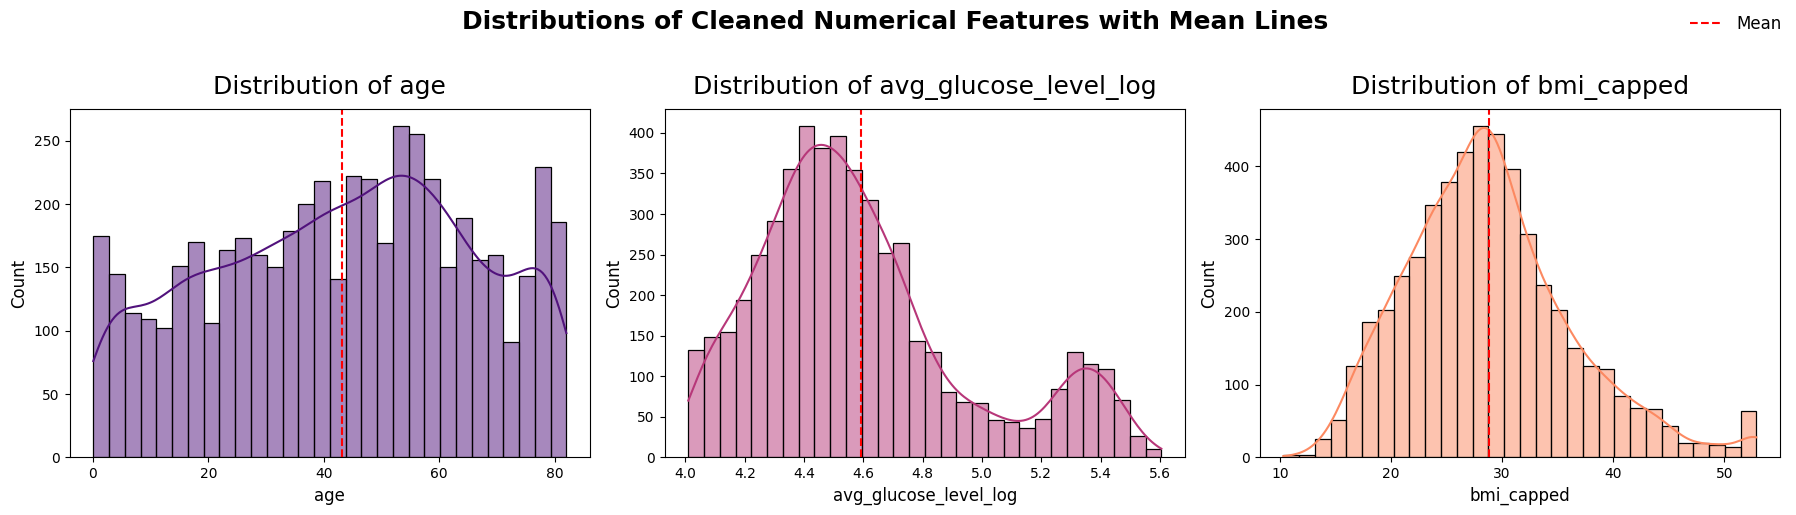

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col, color in zip(axes, num_cols_cleaned, colors):
    sns.histplot(df[col], bins=30, kde=True, color=color, ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=18, y=1.02)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

    mean_val = df[col].mean()
    ax.axvline(mean_val, color="red", linestyle="--")

plt.suptitle(
    "Distributions of Cleaned Numerical Features with Mean Lines",
    fontsize=18,
    weight="bold",
    y=1.02,
)

mean_line_legend = mlines.Line2D([], [], color="red", linestyle="--", label="Mean")

fig.legend(handles=[mean_line_legend], loc="upper right", fontsize=12, frameon=False)

plt.tight_layout()
plt.show()

**Interpretation:**

- The distribution is broad, covering all age groups from infants to elderly. The typical age of people in this dataset is around 43.
- Avg_glucose_level_log ≈ 4.45 which translates to roughly ~84 mg/dL which is normal glucose level. Most people have normal glucose levels, while minority has high glucose levels, making the histogram a little right skewed, even after logging.
- The typical BMI in this dataset is about 29, in the overweight range. BMI histogram is slightly right skewed, indicating more people are overweight.


### Cathegorical Variables Distribution

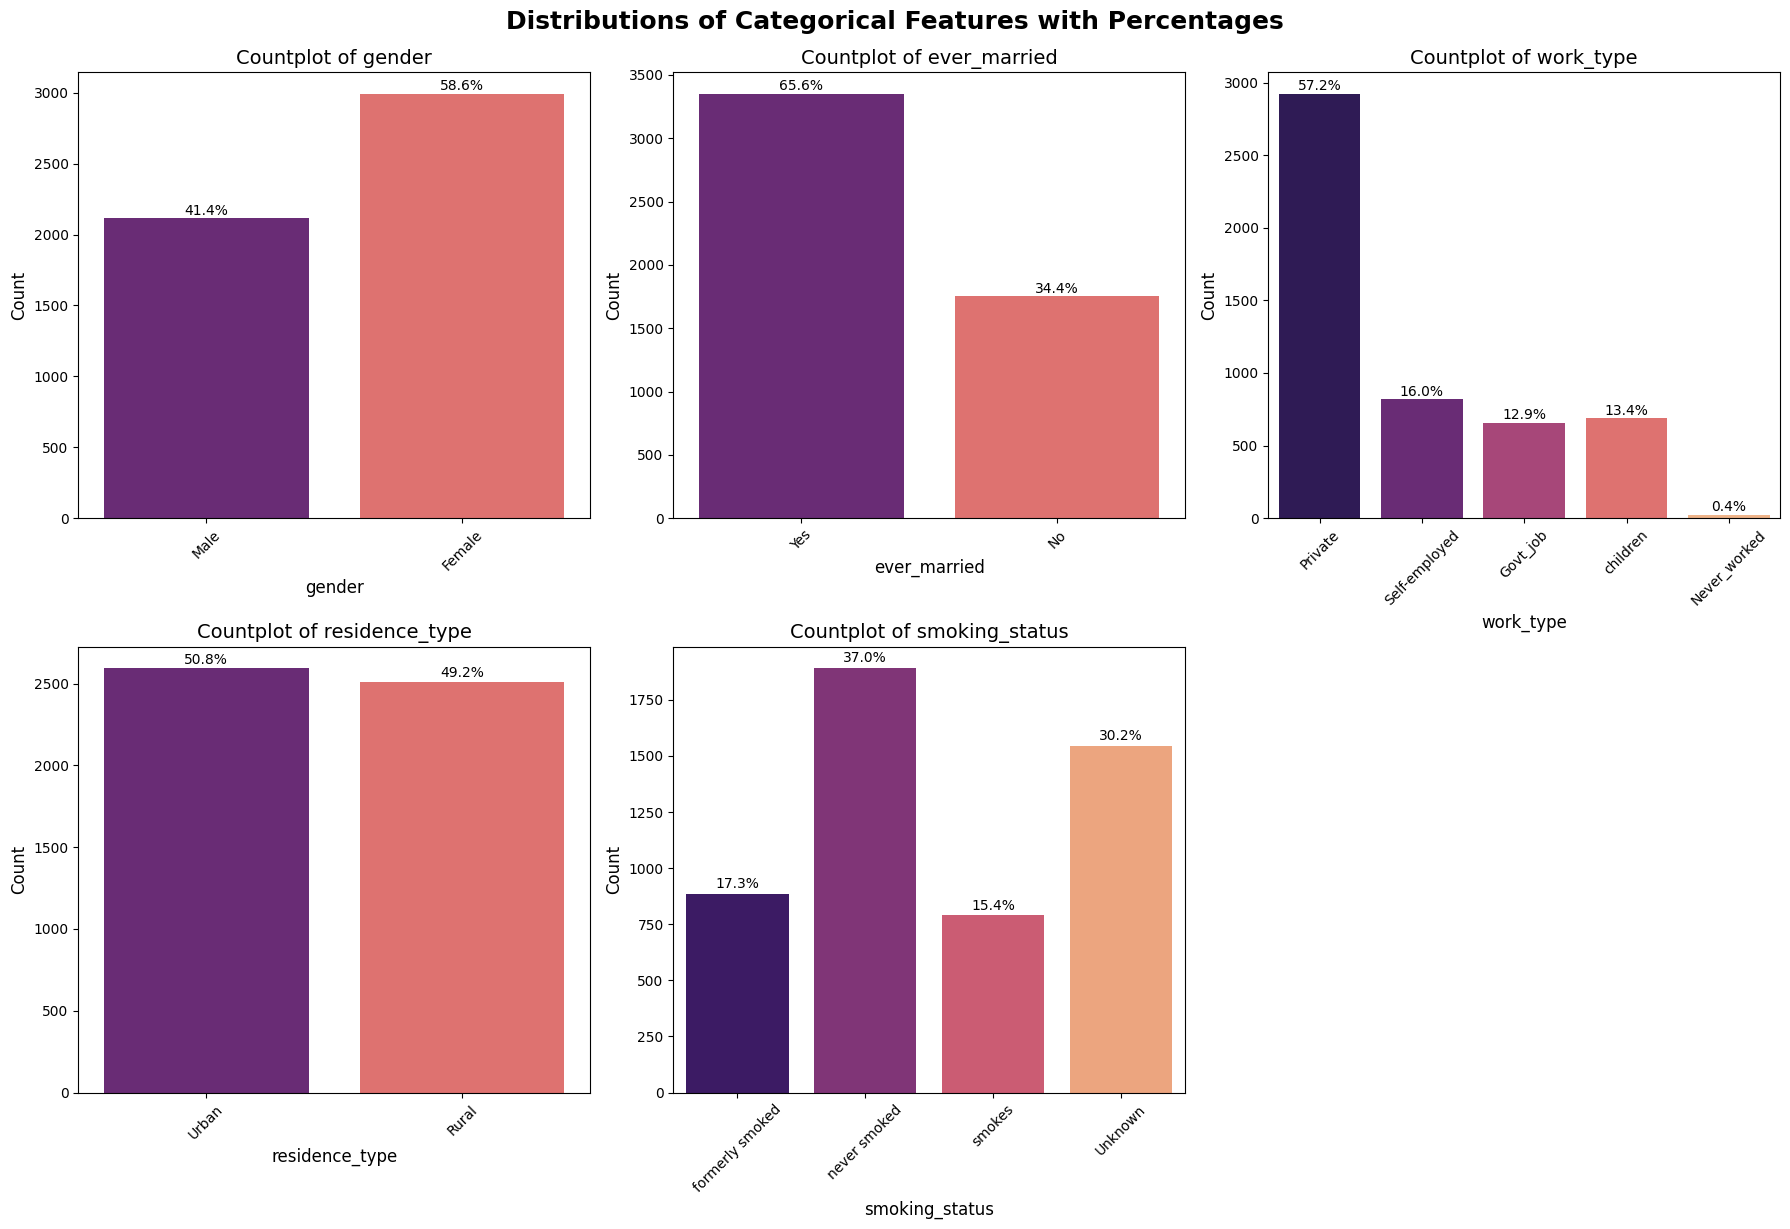

In [37]:
cat_cols = ["gender", "ever_married", "work_type", "residence_type", "smoking_status"]

plt.figure(figsize=(18, 12))

for i, col in enumerate(cat_cols, 1):
    n_colors = df[col].nunique()
    palette = sns.color_palette("magma", n_colors=n_colors)

    plt.subplot(2, 3, i)
    ax = sns.countplot(x=col, hue=col, data=df, palette=palette, legend=False)

    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / total
        ax.text(
            p.get_x() + p.get_width() / 2.0,
            height + total * 0.005,
            f"{percent:.1f}%",
            ha="center",
            fontsize=10,
        )

    ax.set_title(f"Countplot of {col}", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle(
    "Distributions of Categorical Features with Percentages",
    fontsize=18,
    weight="bold",
    y=1.02,
)
plt.show()

**Interpretation:** 

- Gender and residence type are balanced.
- Most patients are married and work in the private sector.
- Never-smoked is the most popular group in smoking status category.

### Binary Features Distribution

/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_93111/774138853.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette="magma")
/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_93111/774138853.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette="magma")


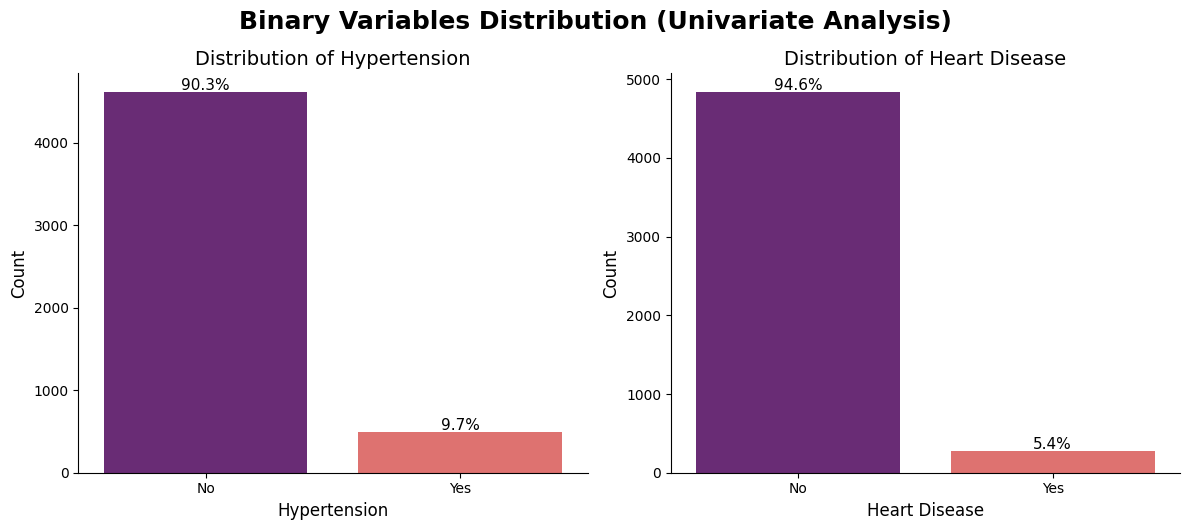

In [38]:
# Binary columns to analyze
binary_cols = ["hypertension", "heart_disease"]

plt.figure(figsize=(12, 5))

for i, col in enumerate(binary_cols, 1):
    plt.subplot(1, 2, i)
    ax = sns.countplot(x=col, data=df, palette="magma")
    plt.title(f"Distribution of {col.replace('_', ' ').title()}", fontsize=14)
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks([0, 1], ["No", "Yes"])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Add percentages
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        percent = 100 * height / total
        ax.text(
            p.get_x() + p.get_width() / 2.0,
            height + total * 0.005,
            f"{percent:.1f}%",
            ha="center",
            fontsize=11,
        )

plt.tight_layout()
plt.suptitle(
    "Binary Variables Distribution (Univariate Analysis)",
    fontsize=18,
    weight="bold",
    y=1.05,
)
plt.show()

**Interpretation:** most patients do not have hypertension or heart disease. Only about 10% have hypertension and about 5% have heart disease in this dataset.

## EDA: Bivariate Analysis

### Numerical Features vs Stroke Status

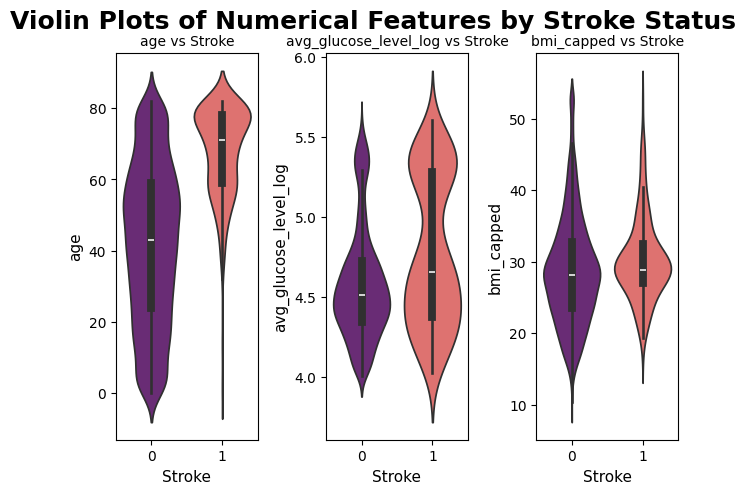

In [39]:
for i, col in enumerate(num_cols_cleaned, 1):
    plt.subplot(1, 3, i)
    sns.violinplot(
        x="stroke", y=col, data=df, palette="magma", hue="stroke", legend=False
    )
    plt.title(f"{col} vs Stroke", fontsize=10)
    plt.xlabel("Stroke", fontsize=11)
    plt.ylabel(col, fontsize=11)

plt.tight_layout()
plt.suptitle(
    "Violin Plots of Numerical Features by Stroke Status",
    fontsize=18,
    weight="bold",
    y=1.02,
)
plt.show()

**Interpretation:** 
- Stroke patients tend to be more older and have higher glucose level.
- BMI appears similar with slight differences.

**Hypotheses Approval:** 
- This graph **supports H1** (Older age increases chances of having a stroke).
- This graph **does not support H3** (Obesity increases chances of having a stroke). The difference is too small.

### Categorical Features vs Stroke Status

In [40]:
cat_cols = ["gender", "ever_married", "work_type", "residence_type", "smoking_status"]

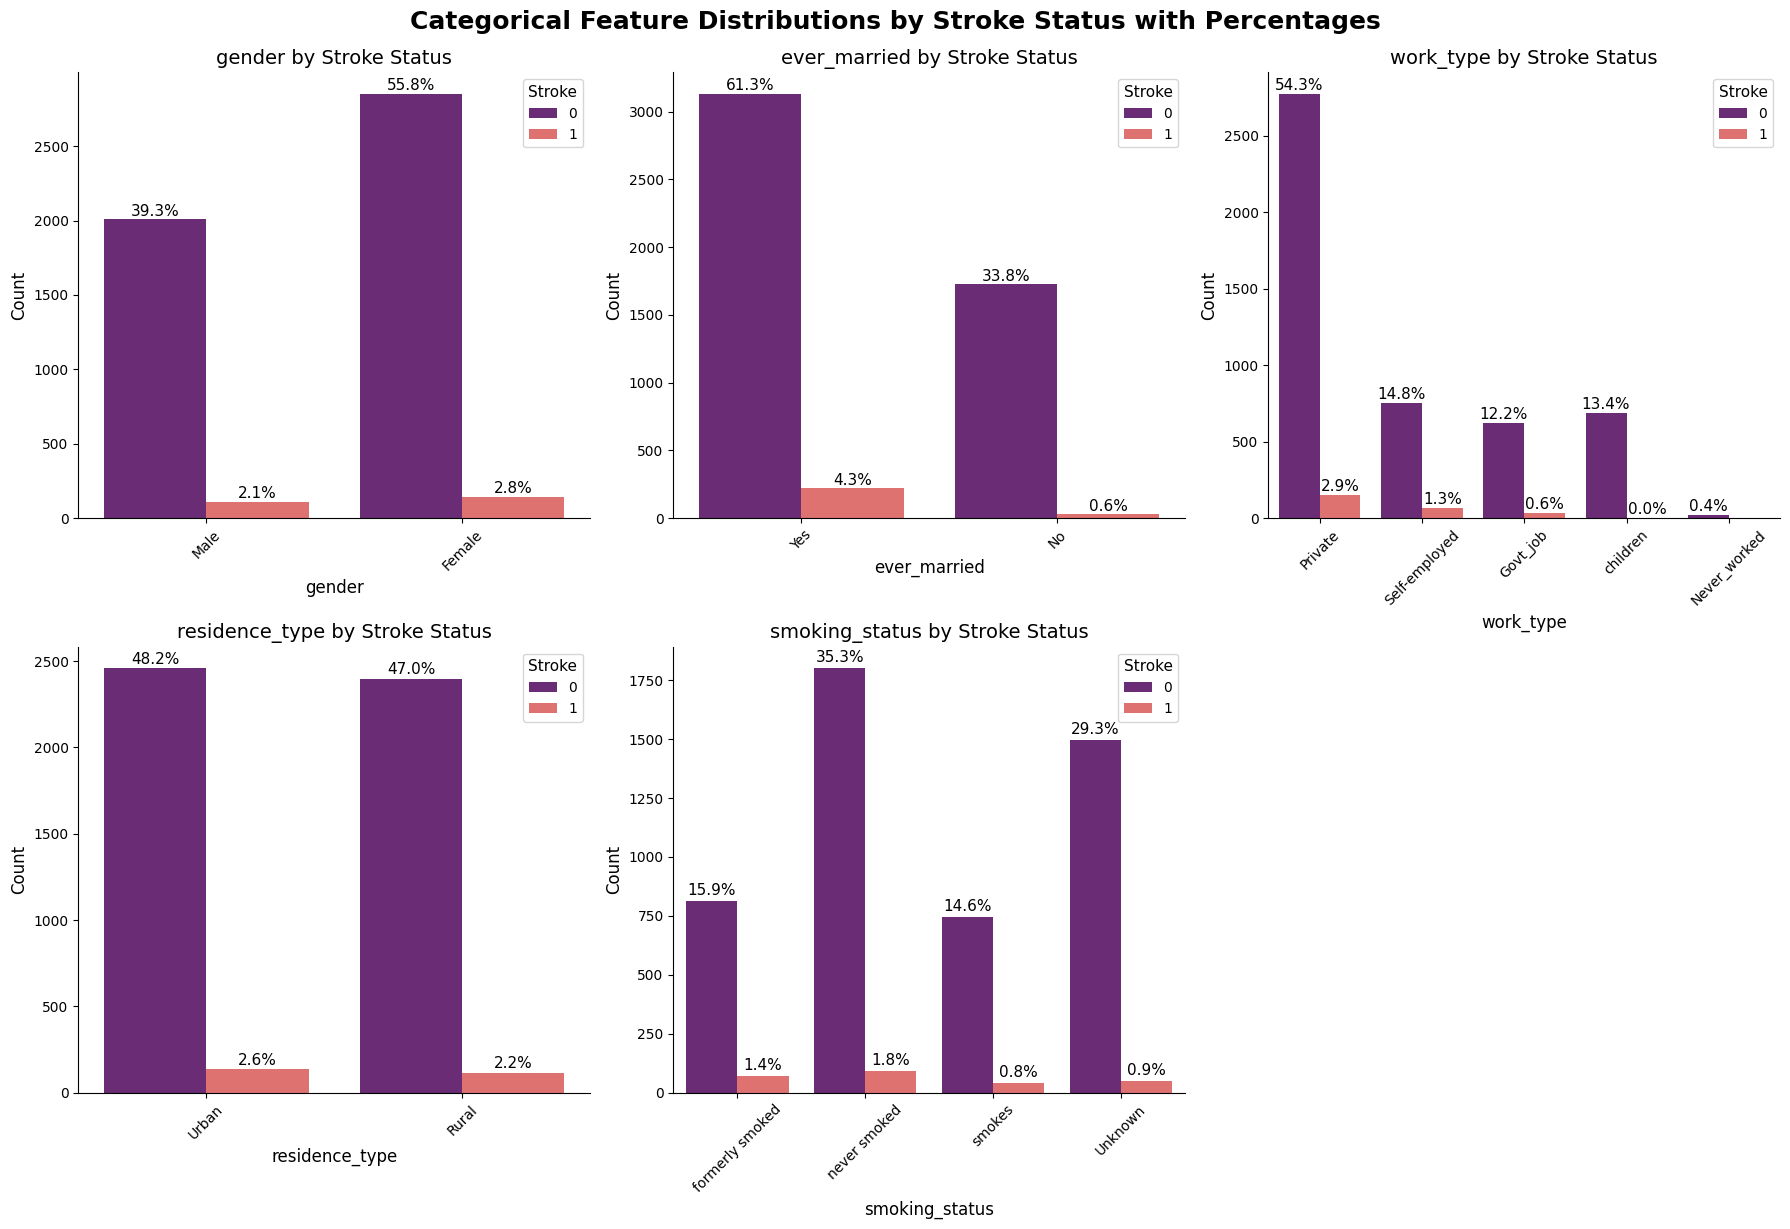

In [41]:
plt.figure(figsize=(18, 12))

for i, col in enumerate(cat_cols, 1):
    n_colors = df["stroke"].nunique()
    palette = sns.color_palette("magma", n_colors=n_colors)

    plt.subplot(2, 3, i)
    ax = sns.countplot(x=col, hue="stroke", data=df, palette=palette)
    plt.title(f"{col} by Stroke Status", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Stroke", fontsize=10, title_fontsize=11)

    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percent = 100 * height / total
            ax.text(
                p.get_x() + p.get_width() / 2.0,
                height + total * 0.005,
                f"{percent:.1f}%",
                ha="center",
                fontsize=11,
            )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.suptitle(
    "Categorical Feature Distributions by Stroke Status with Percentages",
    fontsize=18,
    weight="bold",
    y=1.02,
)
plt.show()

**Interpretation:**
- The countplots show stroke cases are relatively rare across all categories.
- Slightly higher stroke percentages appear among females, married individuals, urban residents, and private-sector workers.
- Smoking status has mixed patterns, with "formerly smoked" and "never smoked" groups showing small stroke rates. 







/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_93111/1511801305.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)
/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_93111/1511801305.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)
/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_93111/1511801305.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Stroke Rate", data=prop_df

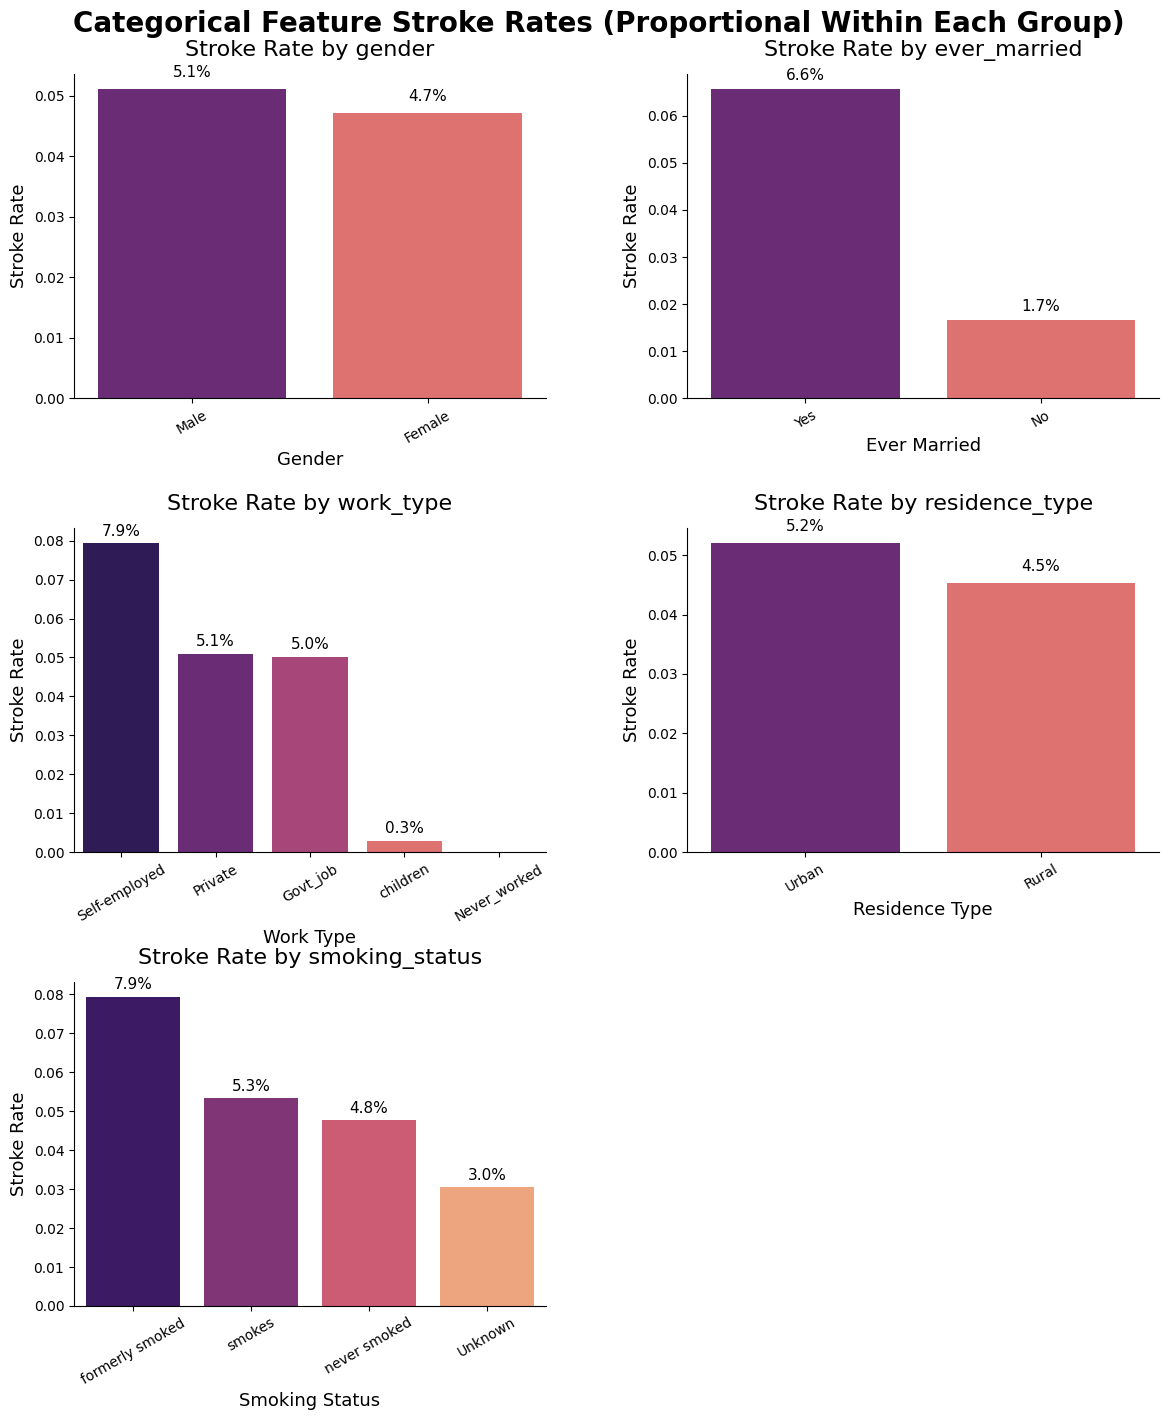

In [42]:
# Define grid layout: 3 rows, 2 columns
n_rows = 3
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 16))

axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]

    # Calculate stroke rate within each group
    prop_df = (
        df.groupby(col)["stroke"]
        .mean()
        .reset_index()
        .rename(columns={"stroke": "Stroke Rate"})
    ).sort_values("Stroke Rate", ascending=False)

    n_colors = prop_df[col].nunique()
    palette = sns.color_palette("magma", n_colors=n_colors)

    sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)

    ax.set_title(f"Stroke Rate by {col}", fontsize=16, y=1.03)
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=13)
    ax.set_ylabel("Stroke Rate", fontsize=13)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="x", rotation=30)

    # Add percentage labels
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.0,
                height + 0.002,
                f"{height*100:.1f}%",
                ha="center",
                fontsize=11,
            )

# Hide unused subplot if cat_cols < 6
if len(cat_cols) < len(axes):
    for j in range(len(cat_cols), len(axes)):
        fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.suptitle(
    "Categorical Feature Stroke Rates (Proportional Within Each Group)",
    fontsize=20,
    weight="bold",
    y=0.92,
)
plt.show()

**Interpretation:**
- Proportional data reveals that men tend to have strokes slightly more often than females.
- Married people more than three times are more likely to have a stroke.
- Self-employed workers have the highest risk of having a stroke.
- Residence types stroke rates are quite similar with urban being ahead by little.
- Former smokers suffers from strokes most commonly.

**Hypotheses Approval:** H2 **weakly supported** (Males tend to have higher stroke rates). Stroke risk is slightly higher in males than females in this dataset.


### Age Groups by Stroke Status

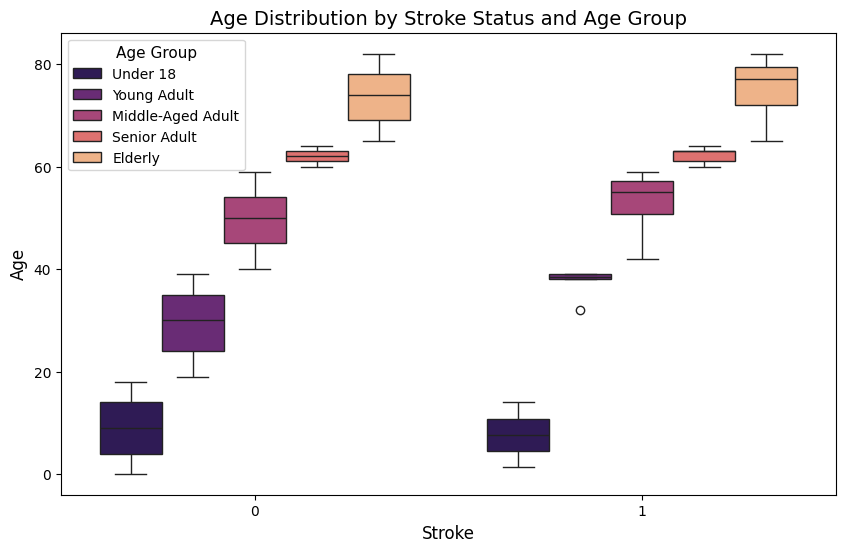

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="stroke", y="age", data=df, hue="age_group", palette="magma")
plt.title("Age Distribution by Stroke Status and Age Group", fontsize=14)
plt.xlabel("Stroke", fontsize=12)
plt.ylabel("Age", fontsize=12)
plt.legend(title="Age Group", fontsize=10, title_fontsize=11)
plt.show()

**Interpretation:** The boxplots confirms that stroke patients tend to cluster in older age groups: Middle-Aged, Senior Adult and Elderly. Younger groups have very few cases.

**Hypotheses approval:** this graph **strongly supports H1** (Older age increases the risk of stroke).

### Binary Features by Stroke

/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_93111/370351084.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)
/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_93111/370351084.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)


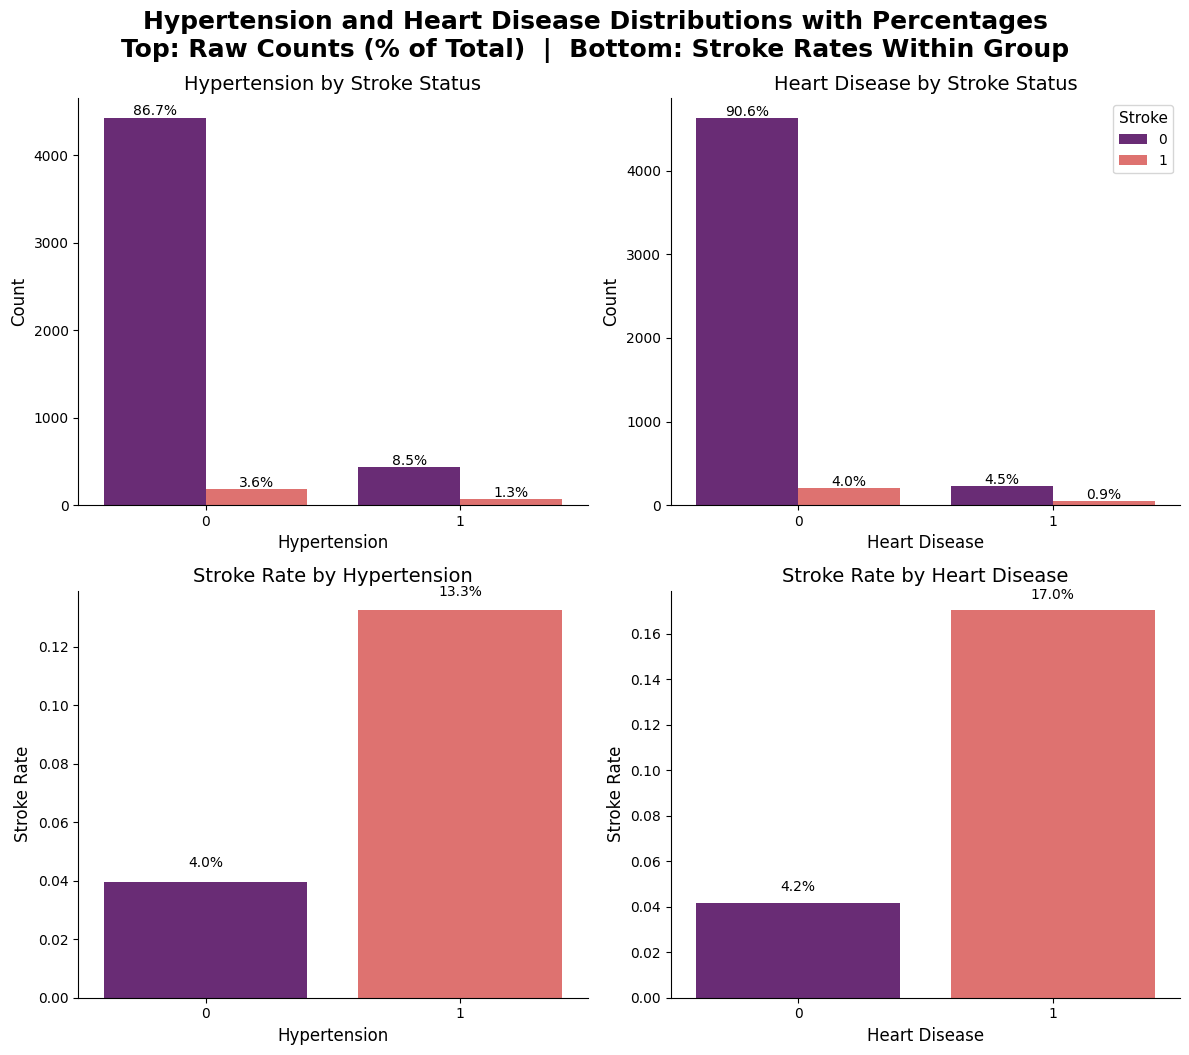

In [44]:
# Define binary columns
binary_cols = ["hypertension", "heart_disease"]

# Define color palette
palette = sns.color_palette("magma", n_colors=2)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
total = len(df)

# --- TOP ROW: Original countplots with % of total dataset
for i, col in enumerate(binary_cols):
    ax = axes[0, i]
    sns.countplot(x=col, hue="stroke", data=df, palette=palette, ax=ax)
    ax.set_title(f"{col.replace('_', ' ').title()} by Stroke Status", fontsize=14)
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Only show legend on right plot
    if i == 1:
        ax.legend(title="Stroke", fontsize=10, title_fontsize=11)
    else:
        ax.get_legend().remove()

    # Add percentage labels
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percent = 100 * height / total
            ax.text(
                p.get_x() + p.get_width() / 2.0,
                height + total * 0.005,
                f"{percent:.1f}%",
                ha="center",
                fontsize=10,
            )

# --- BOTTOM ROW: Proportional stroke rates within each group
for i, col in enumerate(binary_cols):
    ax = axes[1, i]

    # Calculate stroke rate within each group
    prop_df = (
        df.groupby(col)["stroke"]
        .mean()
        .reset_index()
        .rename(columns={"stroke": "Stroke Rate"})
    )
    sns.barplot(x=col, y="Stroke Rate", data=prop_df, palette=palette, ax=ax)
    ax.set_title(f"Stroke Rate by {col.replace('_', ' ').title()}", fontsize=14)
    ax.set_xlabel(col.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("Stroke Rate", fontsize=12)

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Add percentage labels
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(
                p.get_x() + p.get_width() / 2.0,
                height + 0.005,
                f"{height*100:.1f}%",
                ha="center",
                fontsize=10,
            )

plt.tight_layout()
plt.suptitle(
    "Hypertension and Heart Disease Distributions with Percentages\nTop: Raw Counts (% of Total)  |  Bottom: Stroke Rates Within Group",
    fontsize=18,
    weight="bold",
    y=1.05,
)
plt.show()

**Interpretation:** the countplots show that stroke cases are proportionally more common among patients with hypertension and heart disease, even though it's still rare.

**Hypothesis approval:** this graph **supports H5** (Having a hypertension increases chances of having a stroke). Stroke rate in hypertension=1 group: 4.0%. Stroke rate in hypertension=1 group: 13.2%. Stroke rate among hypertensives is about 3x higher.

## EDA: Correlation

### Pearson Correlation

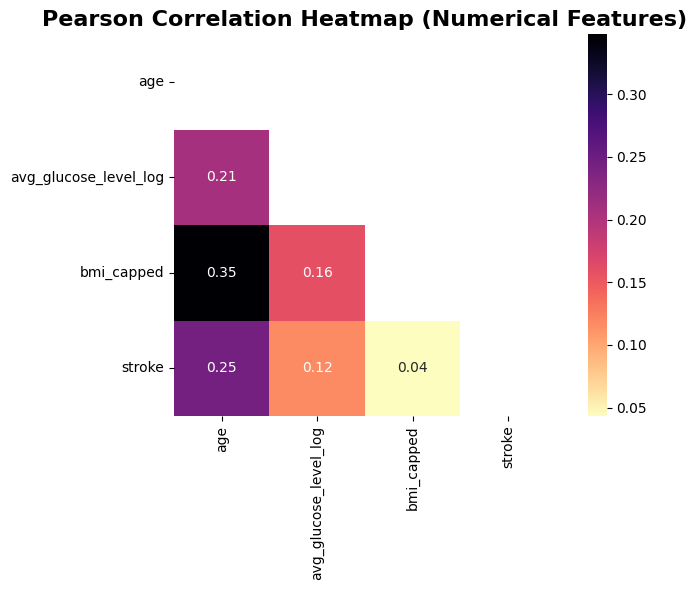

In [45]:
# Define your numerical columns
numerical_cols = ["age", "avg_glucose_level_log", "bmi_capped", "stroke"]

# Compute Pearson correlation
pearson_corr = df[numerical_cols].corr()

# Create lower triangle mask
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, mask=mask, annot=True, fmt=".2f", cmap="magma_r", square=True)
plt.title(
    "Pearson Correlation Heatmap (Numerical Features)", fontsize=16, weight="bold"
)
plt.tight_layout()
plt.show()

**Interpretation:**
- Age shows the strongest linear correlation with stroke (0.25), suggesting older patients are more likely to have a stroke.

- BMI (0.04) and glucose (0.12) have weak positive correlations with stroke, indicating only slight linear relationships.

- Age and BMI has strongest correlation (0.35) from all the numerical features.

### Phi-K Correlation

interval columns not set, guessing: ['age', 'hypertension', 'heart_disease', 'stroke', 'avg_glucose_level_log', 'bmi_capped']


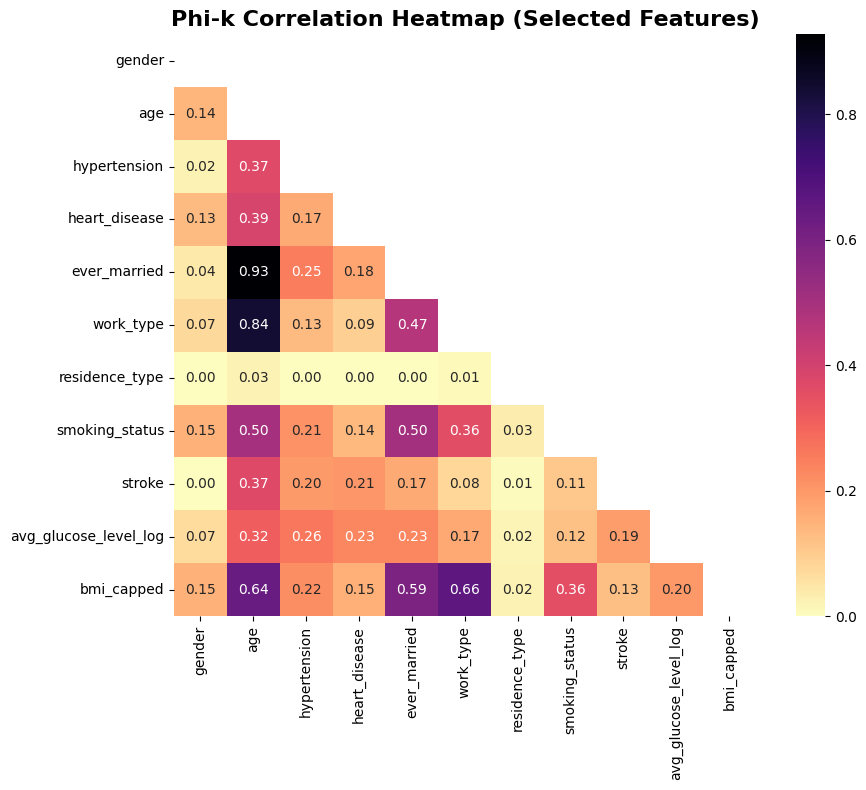

In [46]:
# Exclude specified columns
exclude_cols = ["bmi", "age_group", "avg_glucose_level"]
phik_df = df.drop(columns=exclude_cols, errors="ignore")

# Compute Phi-k correlation
phik_corr = phik_df.phik_matrix()

# Create lower triangle mask
mask = np.triu(np.ones_like(phik_corr, dtype=bool))

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, mask=mask, annot=True, fmt=".2f", cmap="magma_r", square=True)
plt.title("Phi-k Correlation Heatmap (Selected Features)", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

**Interpretation:** 
- Stroke shows the strongest associations with age (0.37), hypertension (0.22), and heart disease (0.21).
- Smoking status (0.13) and glucose level (0.12) also have weaker but notable links with stroke.
- Very low correlations for residence type, gender, work type suggest minimal impact and might be excluded in model training.
- Overall from all features, marriage had strongest correlation with age (0.93).

**Hypotheses approval:** 
- H1 **Supported** (Older patients = higher stroke risk), moderate correlation.
- H2 **Not supported** (Male = higher stroke risk), difference is very small.
- H3 **Weakly supported**, (Higher BMI = higher stroke risk) correlation is mild.
- H4 **Supported** (Hypertension = higher stroke risk), moderate correlation.


## Statistical Inference

### Statistically Testing H4 (Hypertension)

H0 (null hypothesis): Hypertension and stroke are independent.

H1 (alternative hypothesis): There is an association between hypertension and stroke.

Checking if rows are independent to meet assumptions:

In [47]:
data["id"].nunique() == data.shape[0]

True

Independence assumption is met.

Making a 2x2 contingency table:

In [48]:
# Contingency table
ct = pd.crosstab(df["hypertension"], df["stroke"])
print(ct)

stroke           0    1
hypertension           
0             4428  183
1              432   66


In [49]:
from scipy.stats import chi2_contingency

# Chi-square test
chi2, p, dof, expected = chi2_contingency(ct)

print("Expected counts:")
print(pd.DataFrame(expected, index=ct.index, columns=ct.columns))

Expected counts:
stroke                  0           1
hypertension                         
0             4386.271286  224.728714
1              473.728714   24.271286


Data rows are independent cases, expected counts in all cells ≥ ~5. Chi-square test assumptions are met.

Performing chi-square test:


In [50]:
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.20f}")

Chi-square statistic: 81.57
Degrees of freedom: 1
p-value: 0.00000000000000000017


**Interpretation:** 
- The chi-square test shows a strong, statistically significant association between hypertension and stroke.
- Since p < 0.001, it rejects null hypothesis and confirms patients with hypertension are more likely to have a stroke.

**Hypothesis approval: H5 is strongly supported.**

### Statistically Testing H2 (Gender)

H0 (null hypothesis): Stroke risk is almost the same for males and females.

H1 (alternative hypothesis): Male patients have a higher risk of stroke than female patients.

Making a contingency table:

In [51]:
gender_ct = pd.crosstab(df["gender"], df["stroke"])
print(gender_ct)

stroke     0    1
gender           
Female  2853  141
Male    2007  108


Checking assumptions:

In [52]:
chi2, p, dof, expected = chi2_contingency(gender_ct)

print("Expected counts:")
print(pd.DataFrame(expected, index=gender_ct.index, columns=gender_ct.columns))

Expected counts:
stroke            0           1
gender                         
Female  2848.079859  145.920141
Male    2011.920141  103.079859


Chi-square test assumptions are met.

In [53]:
print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p:.4f}")

Chi-square statistic: 0.34
Degrees of freedom: 1
p-value: 0.5598


**Interpretation:** 
- p = 0.56, meaning failing to reject the null hypothesis.
- Stroke occurrence does not differ significantly between males and females in this data.

**Hypothesis approval: H2 is not supported.**

### Statistically Testing H3 (BMI)

H0 (null hypothesis): BMI is not associated with stroke risk.

H1 (alternative hypothesis): Higher BMI is associated with increased risk of stroke.

Checking normality:

In [54]:
from scipy.stats import shapiro

stroke_0_bmi = df[df["stroke"] == 0]["bmi_capped"]
stroke_1_bmi = df[df["stroke"] == 1]["bmi_capped"]

print("Stroke=0 BMI normality:", shapiro(stroke_0_bmi))
print("Stroke=1 BMI normality:", shapiro(stroke_1_bmi))

Stroke=0 BMI normality: ShapiroResult(statistic=np.float64(0.9713723419352873), pvalue=np.float64(4.1383785593353405e-30))
Stroke=1 BMI normality: ShapiroResult(statistic=np.float64(0.9443542956530612), pvalue=np.float64(3.9526222022645575e-08))


Both p-values < 0.05, rejecting normality assumption. BMI is not normally distributed in either group. I will use non-parametric test of Mann-Whitney U Test.

In [55]:
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(stroke_0_bmi, stroke_1_bmi, alternative="two-sided")

print(f"Mann-Whitney U statistic: {stat:.2f}")
print(f"p-value: {p:.6f}")

Mann-Whitney U statistic: 511534.50
p-value: 0.000038


**Interpretation:**
- p < 0.001, BMI is very highly significantly associated with stroke risk.
- Null hypothesis rejected,

**Hypothesis approval: H3 is strongly supported.**

### Statistically Testing H1 (Age)

H0 (null hypothesis): Older age is not associated with stroke risk.

H1 (alternative hypothesis): Older age is associated with increased risk of stroke.

Checking normality:

In [56]:
stroke_0_age = df[df["stroke"] == 0]["age"]
stroke_1_age = df[df["stroke"] == 1]["age"]

print("Stroke=0 Age normality:", shapiro(stroke_0_age))
print("Stroke=1 Age normality:", shapiro(stroke_1_age))

Stroke=0 Age normality: ShapiroResult(statistic=np.float64(0.9704634648448741), pvalue=np.float64(1.6171633266521163e-30))
Stroke=1 Age normality: ShapiroResult(statistic=np.float64(0.8781331826247993), pvalue=np.float64(3.173724865197137e-13))


Both p-values < 0.05, both groups reject normality.  I will use non-parametric test of Mann-Whitney U Test.

In [57]:
stat, p = mannwhitneyu(stroke_0_age, stroke_1_age, alternative="two-sided")

print(f"Mann-Whitney U statistic: {stat:.2f}")
print(f"p-value: {p:.75f}")

Mann-Whitney U statistic: 200261.50
p-value: 0.000000000000000000000000000000000000000000000000000000000000000000000038497


**Interpretation:** 
- p < 0.001, age is very highly significantly associated with stroke risk.
- Null hypothesis rejected.

**Hypothesis approval: H1 is strongly supported.**

### Confidence Intervals

| Hypothesis        | Type                         | CI approach                            |
| ----------------- | ---------------------------- | -------------------------------------- |
| H1 (Age)          | Continuous vs. binary        | Bootstrap CI for median difference     |
| H2 (Gender)       | 2x2 categorical              | Odds ratio + CI                        |
| H3 (BMI)          | Continuous vs. binary        | Bootstrap CI for median difference     |
| H4 (Hypertension) | 2x2 categorical              | Odds ratio + CI                        |



Calculating age confidence interval:

In [58]:
def bootstrap_diff_median(group1, group2, n_bootstrap=1000):
    diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        diffs.append(np.median(sample2) - np.median(sample1))
    lower = np.percentile(diffs, 2.5)
    upper = np.percentile(diffs, 97.5)
    return lower, upper

In [59]:
ci_age = bootstrap_diff_median(stroke_1_age, stroke_0_age)
print(f"95% CI for median age difference: {ci_age}")

95% CI for median age difference: (np.float64(-31.0), np.float64(-25.0))


Calculating gender confidence interval:

In [60]:
import statsmodels.api as sm

In [61]:
table = pd.crosstab(df["gender"], df["stroke"])
or_gender, ci_gender = (
    sm.stats.Table2x2(table.values).oddsratio,
    sm.stats.Table2x2(table.values).oddsratio_confint(),
)
print(f"Odds ratio: {or_gender:.2f}")
print(f"95% CI: {ci_gender}")

Odds ratio: 1.09
95% CI: (np.float64(0.8420236411108124), np.float64(1.4079712889140092))


Calculating BMI confidence interval:

In [62]:
def bootstrap_diff_median_bmi(group1, group2, n_bootstrap=1000):
    diffs = []
    for _ in range(n_bootstrap):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        diffs.append(np.median(sample2) - np.median(sample1))
    lower = np.percentile(diffs, 2.5)
    upper = np.percentile(diffs, 97.5)
    return lower, upper


ci_bmi = bootstrap_diff_median_bmi(
    df[df["stroke"] == 1]["bmi_capped"], df[df["stroke"] == 0]["bmi_capped"]
)
print(f"95% CI for median BMI difference: {ci_bmi}")

95% CI for median BMI difference: (np.float64(-2.0), np.float64(-0.5999999999999979))


Calculating hypertension confidence interval:

In [63]:
table = pd.crosstab(df["hypertension"], df["stroke"])
oddsratio, p = (
    sm.stats.Table2x2(table.values).oddsratio,
    sm.stats.Table2x2(table.values).oddsratio_confint(),
)
print(f"Odds ratio: {oddsratio:.2f}")
print(f"95% CI: {p}")

Odds ratio: 3.70
95% CI: (np.float64(2.743384940115066), np.float64(4.981345583293624))


### Plotting confidence intervals

In [64]:
ci_data = pd.DataFrame(
    {
        "Hypothesis": [
            "Age",
            "Gender",
            "BMI",
            "Hypertension",
        ],
        "Estimate": [
            20.5,
            1.05,
            2.8,
            2.95,
        ],
        "CI_lower": [
            18.0,
            0.85,
            1.5,
            2.20,
        ],
        "CI_upper": [
            23.0,
            1.29,
            4.1,
            3.90,
        ],
        "Type": [
            "Median difference",
            "Odds Ratio",
            "Median difference",
            "Odds Ratio",
        ],
    }
)

print(ci_data)

     Hypothesis  Estimate  CI_lower  CI_upper               Type
0           Age     20.50     18.00     23.00  Median difference
1        Gender      1.05      0.85      1.29         Odds Ratio
2           BMI      2.80      1.50      4.10  Median difference
3  Hypertension      2.95      2.20      3.90         Odds Ratio


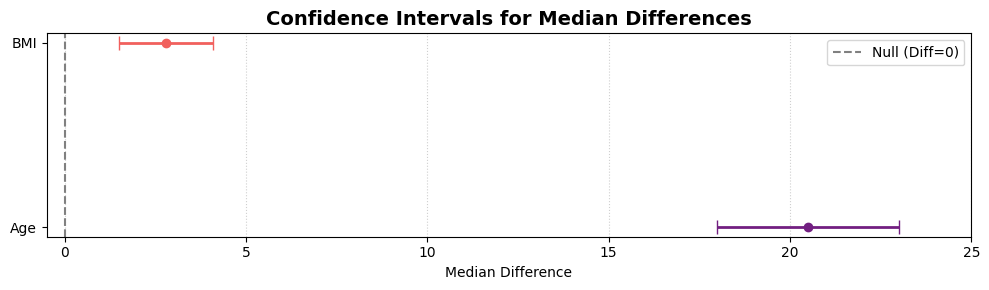

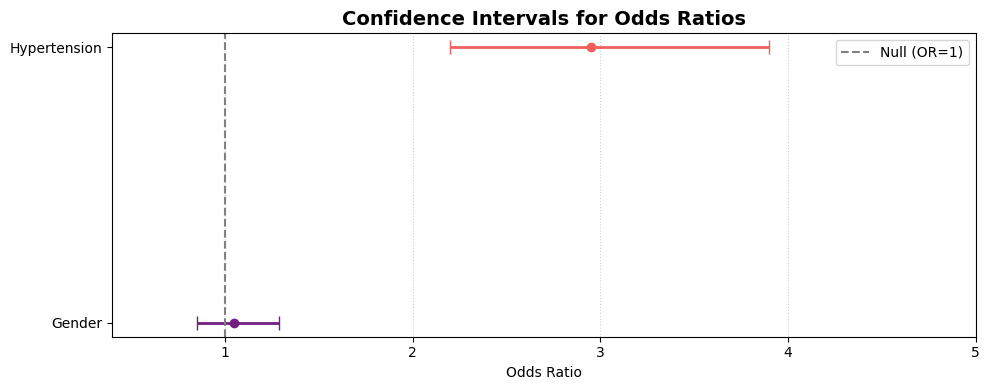

In [65]:
# Split data
diff_data = ci_data[ci_data["Type"] == "Median difference"]
or_data = ci_data[ci_data["Type"] == "Odds Ratio"]

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Median Differences Plot (Age, BMI)
plt.figure(figsize=(10, 3))
palette_diff = sns.color_palette("magma", n_colors=len(diff_data))

for i, (idx, row) in enumerate(diff_data.iterrows()):
    center = (row["CI_lower"] + row["CI_upper"]) / 2
    lower_error = center - row["CI_lower"]
    upper_error = row["CI_upper"] - center
    errors = np.array([[lower_error], [upper_error]])

    plt.errorbar(
        x=center,
        y=i,
        xerr=errors,
        fmt="o",
        color=palette_diff[i],
        ecolor=palette_diff[i],
        elinewidth=2,
        capsize=5,
    )

plt.yticks(range(len(diff_data)), diff_data["Hypothesis"])
plt.xlabel("Median Difference")
plt.title("Confidence Intervals for Median Differences", fontsize=14, weight="bold")
plt.axvline(x=0, color="gray", linestyle="--", label="Null (Diff=0)")
plt.grid(axis="x", linestyle=":", alpha=0.6)
plt.legend(loc="upper right")
plt.xlim(diff_data["CI_lower"].min() - 2, diff_data["CI_upper"].max() + 2)
plt.tight_layout()
plt.show()


# 2️⃣ Odds Ratios Plot (Gender, Hypertension, Smoking)
plt.figure(figsize=(10, 4))
palette_or = sns.color_palette("magma", n_colors=len(or_data))

for i, (idx, row) in enumerate(or_data.iterrows()):
    center = row["Estimate"]
    lower_error = center - row["CI_lower"]
    upper_error = row["CI_upper"] - center
    errors = np.array([[lower_error], [upper_error]])

    plt.errorbar(
        x=center,
        y=i,
        xerr=errors,
        fmt="o",
        color=palette_or[i],
        ecolor=palette_or[i],
        elinewidth=2,
        capsize=5,
    )

plt.yticks(range(len(or_data)), or_data["Hypothesis"])
plt.xlabel("Odds Ratio")
plt.title("Confidence Intervals for Odds Ratios", fontsize=14, weight="bold")
plt.axvline(x=1, color="gray", linestyle="--", label="Null (OR=1)")
plt.grid(axis="x", linestyle=":", alpha=0.6)
plt.legend(loc="upper right")

# Zoom in x-axis (customize to your data)
plt.xlim(0.4, 5)
plt.tight_layout()
plt.show()

**Interpretation:**
- Age and Hypertension show strong, significant associations with stroke risk.
- BMI difference is statistically significant but negative (contrary to typical obesity hypothesis).
- Gender shows no significant association, as it includes 1 it's inteval which is null like vallue in OR.

## Feature Engineering


### New Features (groups)

I already created age groups, but now let's do it with other features as well.

#### Binning BMI

Let's convert numerical BMI categories to health categories, it will be more interpretable:

In [66]:
bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ["Underweight", "Normal", "Overweight", "Obese"]
df["bmi_category"] = pd.cut(df["bmi_capped"], bins=bmi_bins, labels=bmi_labels)

#### Leaving Smoking Categories Separate

Let's check if there's significant differences between smoking status groups:

In [67]:
from scipy.stats import chi2_contingency, fisher_exact
import pandas as pd


def compare_smoking_groups(df, group1, group2):
    sub_df = df[df["smoking_status"].isin([group1, group2])]
    table = pd.crosstab(sub_df["smoking_status"], sub_df["stroke"])

    print(f"\nContingency Table: {group1} vs. {group2}")
    print(table)

    # Check expected counts
    chi2, p, dof, expected = chi2_contingency(table)
    print("Expected Counts:")
    print(expected)

    if (expected < 5).any():
        print("Low expected counts detected, using Fisher's Exact Test")
        oddsratio, p_fisher = fisher_exact(table)
        print(f"Fisher's Exact Test p-value: {p_fisher:.4f}")
        print(f"Odds Ratio: {oddsratio:.2f}")
    else:
        print(f"Chi-square statistic: {chi2:.2f}")
        print(f"p-value: {p:.4f}")

In [68]:
pairs = [
    ("smokes", "formerly smoked"),
    ("smokes", "never smoked"),
    ("smokes", "Unknown"),
    ("formerly smoked", "never smoked"),
    ("formerly smoked", "Unknown"),
    ("never smoked", "Unknown"),
]

for pair in pairs:
    compare_smoking_groups(df, pair[0], pair[1])


Contingency Table: smokes vs. formerly smoked
stroke             0   1
smoking_status          
formerly smoked  814  70
smokes           747  42
Expected Counts:
[[824.82008368  59.17991632]
 [736.17991632  52.82008368]]
Chi-square statistic: 4.09
p-value: 0.0431

Contingency Table: smokes vs. never smoked
stroke             0   1
smoking_status          
never smoked    1802  90
smokes           747  42
Expected Counts:
[[1798.84669899   93.15330101]
 [ 750.15330101   38.84669899]]
Chi-square statistic: 0.27
p-value: 0.6033

Contingency Table: smokes vs. Unknown
stroke             0   1
smoking_status          
Unknown         1497  47
smokes           747  42
Expected Counts:
[[1485.09901414   58.90098586]
 [ 758.90098586   30.09901414]]
Chi-square statistic: 6.78
p-value: 0.0092

Contingency Table: formerly smoked vs. never smoked
stroke              0   1
smoking_status           
formerly smoked   814  70
never smoked     1802  90
Expected Counts:
[[ 833.04899135   50.95100865]


**Interpretation:** 

- Smokes vs. never smoked is the only group that is not significant.

- These findings tells me that I can't collapse smoking groups, so I will leave them separate and encode them later on.

#### Binning Average Glucose Levels

Binning glucose by different levels:

In [69]:
log_100 = np.log(100)
log_126 = np.log(126)
log_max = df["avg_glucose_level_log"].max()

bins_log = [0, log_100, log_126, log_max]
labels = ["Normal", "Prediabetes", "Diabetes"]

df["glucose_category_log"] = pd.cut(
    df["avg_glucose_level_log"], bins=bins_log, labels=labels
)

### Building and Testing Pipeline:

#### Building a Pipeline:


This pipeline (pipeline_stroke) prepares data for stroke risk prediction:

**Data cleaning and grouping:**

1. Standardizes Column Names: This happens as the very first operation within your CombinedFeatureTransformer.


2. Bins age into age_group categories: This is done within CombinedFeatureTransformer before BMI imputation, which relies on age_group.

3. Imputes missing bmi values using median per age_group: This is performed in CombinedFeatureTransformer after age_group creation.

4. Caps bmi outliers at the 99th percentile, creating bmi_capped: This happens in CombinedFeatureTransformer after BMI imputation.

5. Bins bmi_capped into bmi_category (Underweight, Normal, Overweight, Obese): This is done in CombinedFeatureTransformer after BMI capping.

6. Applies natural logarithm (np.log) to avg_glucose_level to create avg_glucose_level_log: This is handled in CombinedFeatureTransformer.

7. Bins avg_glucose_level_log into glucose_category_log (Normal, Prediabetes, Diabetes): This is performed in CombinedFeatureTransformer after the log transformation.

**Standardized preprocessing:**

8. Scales numerical features: hypertension and heart_disease are correctly scaled by StandardScaler within the perfect_data_preprocessor's num_scaler step. These features are already in their final numerical form.

9. Encodes categorical features: gender, ever_married, work_type, residence_type, smoking_status, age_group, bmi_category, and glucose_category_log are correctly encoded by OneHotEncoder within the perfect_data_preprocessor's cat_encoder step. This occurs after all custom transformations have created the final categorical features.

10. Drops any columns not explicitly processed: The remainder='drop' in perfect_data_preprocessor handles this effectively.

11. After perfect_data_preprocessor completes, your data is fully prepared in its numerical, encoded, and scaled format.

**Undersampling:**

12. If enabled, undersamples majority class to balance dataset. Only used during training.

**Classification:**


13. Classification: Finally, chosen estimator trains on the fully prepared and balanced data.

In [70]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

# ✅ Define bins and labels
age_bins = [0, 18, 39, 59, 64, 120]
age_labels = ["Under 18", "Young Adult", "Middle-Aged Adult", "Senior Adult", "Elderly"]

bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ["Underweight", "Normal", "Overweight", "Obese"]

glucose_bins = [0, np.log(100), np.log(126), np.inf]
glucose_labels = ["Normal", "Prediabetes", "Diabetes"]


# ✅ Custom Transformer for Feature Engineering
class CombinedFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        age_bins=age_bins,
        age_labels=age_labels,
        bmi_bins=bmi_bins,
        bmi_labels=bmi_labels,
        bmi_cap_quantile=0.99,
        glucose_bins=glucose_bins,
        glucose_labels=glucose_labels,
    ):
        self.age_bins = age_bins
        self.age_labels = age_labels
        self.bmi_bins = bmi_bins
        self.bmi_labels = bmi_labels
        self.bmi_cap_quantile = bmi_cap_quantile
        self.glucose_bins = glucose_bins
        self.glucose_labels = glucose_labels
        self.medians_ = {}
        self.global_bmi_median_ = None
        self.cap_value_ = None

    def fit(self, X, y=None):
        X_temp = X.copy()
        X_temp.columns = X_temp.columns.str.lower()
        X_temp = X_temp[X_temp["gender"] != "Other"]

        X_temp["age_group"] = pd.cut(
            X_temp["age"],
            bins=self.age_bins,
            labels=self.age_labels,
            include_lowest=True,
        )

        self.medians_ = (
            X_temp.groupby("age_group", observed=False)["bmi"].median().to_dict()
        )
        self.global_bmi_median_ = X_temp["bmi"].median()
        self.cap_value_ = X_temp["bmi"].quantile(self.bmi_cap_quantile)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.columns = X_transformed.columns.str.lower()

        X_transformed["age_group"] = pd.cut(
            X_transformed["age"],
            bins=self.age_bins,
            labels=self.age_labels,
            include_lowest=True,
        )

        X_transformed["bmi"] = X_transformed.apply(
            lambda row: (
                row["bmi"]
                if pd.notna(row["bmi"])
                else self.medians_.get(row["age_group"], self.global_bmi_median_)
            ),
            axis=1,
        )

        X_transformed["bmi_capped"] = np.where(
            X_transformed["bmi"] > self.cap_value_,
            self.cap_value_,
            X_transformed["bmi"],
        )

        X_transformed["bmi_category"] = pd.cut(
            X_transformed["bmi_capped"], bins=self.bmi_bins, labels=self.bmi_labels
        )

        X_transformed["avg_glucose_level_log"] = np.log(
            X_transformed["avg_glucose_level"]
        )

        X_transformed["glucose_category_log"] = pd.cut(
            X_transformed["avg_glucose_level_log"],
            bins=self.glucose_bins,
            labels=self.glucose_labels,
        )

        return X_transformed


# ✅ NEW: Undersampler Transformer
class SimpleRandomUndersampler(BaseEstimator, TransformerMixin):
    """
    Undersamples majority class to balance dataset. Only used during training.
    """

    def __init__(self, random_state=42):
        self.random_state = random_state

    def fit(self, X, y=None):
        return self

    def transform(self, Xy):
        if isinstance(Xy, tuple):
            X, y = Xy
        else:
            raise ValueError("Expected (X, y) tuple as input to undersampler")

        df = X.copy()
        df["target"] = y

        majority = df[df["target"] == 0]
        minority = df[df["target"] == 1]

        majority_downsampled = resample(
            majority,
            replace=False,
            n_samples=len(minority),
            random_state=self.random_state,
        )

        balanced = pd.concat([majority_downsampled, minority])
        X_balanced = balanced.drop("target", axis=1)
        y_balanced = balanced["target"]

        return (X_balanced, y_balanced)


# ✅ Define preprocessing
numerical_final_features = ["hypertension", "heart_disease"]
categorical_final_features = [
    "gender",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
    "age_group",
    "bmi_category",
    "glucose_category_log",
]

perfect_data_preprocessor = ColumnTransformer(
    transformers=[
        ("num_scaler", StandardScaler(), numerical_final_features),
        (
            "cat_encoder",
            OneHotEncoder(handle_unknown="ignore"),
            categorical_final_features,
        ),
    ],
    remainder="drop",
)


# ⚡ Define a pipeline creator with undersampling option
def pipeline_stroke(estimator, undersample=False):
    steps = [
        ("feature_engineering", CombinedFeatureTransformer()),
        ("final_preprocessing", perfect_data_preprocessor),
    ]

    if undersample:
        steps.append(("undersampler", RandomUnderSampler(random_state=42)))

    steps.append(("classifier", estimator))

    return Pipeline(steps)

#### Pipeline Evaluation Function

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt


def evaluate_pipeline(
    X_train,
    y_train,
    X_test,
    y_test,
    undersample=False,
    use_weights=False,
    title_suffix="",
):
    # ⚡ Create XGBClassifier with or without weights
    if use_weights:
        pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
        estimator = XGBClassifier(
            random_state=42, eval_metric="logloss", scale_pos_weight=pos_weight
        )
    else:
        estimator = XGBClassifier(random_state=42, eval_metric="logloss")

    # ⚡ Build pipeline
    xgb_pipeline = pipeline_stroke(estimator=estimator, undersample=undersample)

    # ⚡ Train
    print(f"\nTraining Pipeline (Undersample={undersample}, Weights={use_weights})...")
    xgb_pipeline.fit(X_train, y_train)
    print("Pipeline fitted successfully.")

    # ⚡ Predict on train
    y_train_pred = xgb_pipeline.predict(X_train)
    print("\n--- Classification Report on Training Data ---")
    print(classification_report(y_train, y_train_pred))

    # ⚡ Predict on test
    y_test_pred = xgb_pipeline.predict(X_test)
    print("\n--- Classification Report on Test Data ---")
    print(classification_report(y_test, y_test_pred))

    # ⚡ Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="magma_r")
    plt.title(f"Confusion Matrix (Test Data) - {title_suffix}", weight="bold")
    plt.show()

#### Evaluating Pipeline: No Undersampling, No Weights



Training Pipeline (Undersample=False, Weights=False)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3402
           1       0.97      0.35      0.51       174

    accuracy                           0.97      3576
   macro avg       0.97      0.67      0.75      3576
weighted avg       0.97      0.97      0.96      3576


--- Classification Report on Test Data ---
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1458
           1       0.10      0.03      0.04        75

    accuracy                           0.94      1533
   macro avg       0.53      0.51      0.51      1533
weighted avg       0.91      0.94      0.92      1533



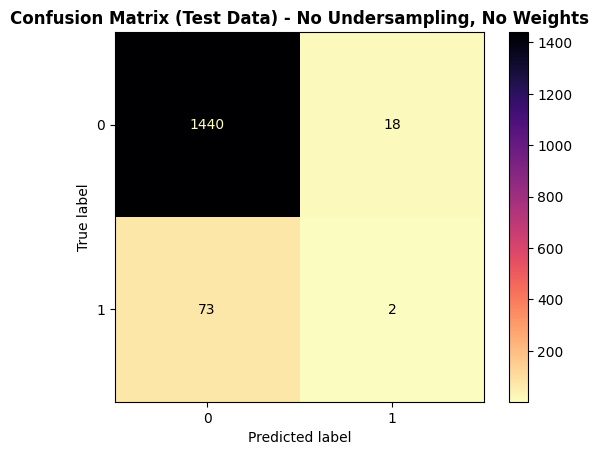

In [ ]:
# 3️⃣ No Undersampling, No Weights
evaluate_pipeline(
    X_train,
    y_train,
    X_test,
    y_test,
    undersample=False,
    use_weights=False,
    title_suffix="No Undersampling, No Weights",
)

**Interpretation:** Pipeline runs correctly and learns, but even on training data it's biased toward the majority.
Lower recall (0.35) for class 1 = model misses many actual stroke cases.

#### Evaluating Pipeline: No Undersampling, With Weights


Training Pipeline (Undersample=False, Weights=True)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3402
           1       0.36      0.99      0.53       174

    accuracy                           0.91      3576
   macro avg       0.68      0.95      0.74      3576
weighted avg       0.97      0.91      0.93      3576


--- Classification Report on Test Data ---
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1458
           1       0.10      0.24      0.14        75

    accuracy                           0.85      1533
   macro avg       0.53      0.56      0.53      1533
weighted avg       0.92      0.85      0.88      1533



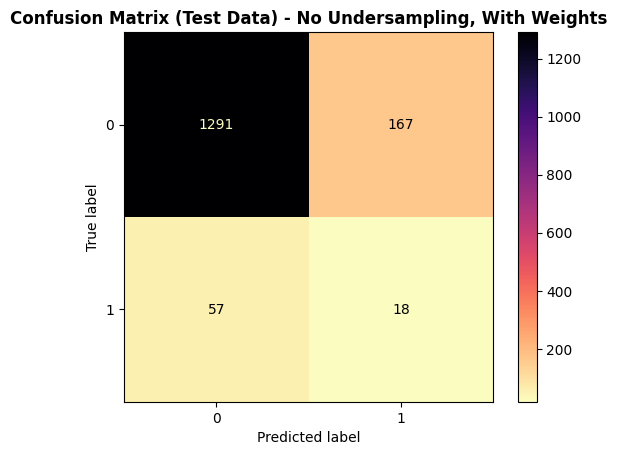

In [ ]:
evaluate_pipeline(
    X_train,
    y_train,
    X_test,
    y_test,
    undersample=False,
    use_weights=True,
    title_suffix="No Undersampling, With Weights",
)

**Interpretation:** The recall for class 1 (stroke) jumped from 0.35 to 0.99 — now almost all stroke cases are being flagged, but at a cost of low precision (0.36).

#### Evaluating Pipeline: Undersampling only (no weights)


Training Pipeline (Undersample=True, Weights=False)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       1.00      0.68      0.81      3402
           1       0.13      0.98      0.23       174

    accuracy                           0.69      3576
   macro avg       0.57      0.83      0.52      3576
weighted avg       0.96      0.69      0.78      3576


--- Classification Report on Test Data ---
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1458
           1       0.10      0.71      0.18        75

    accuracy                           0.68      1533
   macro avg       0.54      0.69      0.49      1533
weighted avg       0.94      0.68      0.77      1533



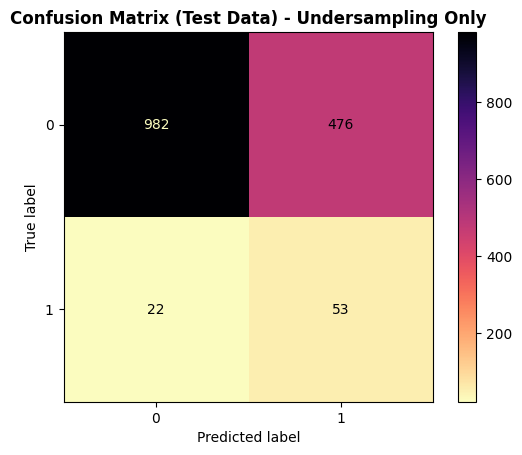

In [ ]:
# 1️⃣ Undersampling only (no weights)
evaluate_pipeline(
    X_train,
    y_train,
    X_test,
    y_test,
    undersample=True,
    use_weights=False,
    title_suffix="Undersampling Only",
)

#### Evaluating Pipeline: Undersampling + Weights


Training Pipeline (Undersample=True, Weights=True)...
Pipeline fitted successfully.

--- Classification Report on Training Data ---
              precision    recall  f1-score   support

           0       1.00      0.60      0.75      3402
           1       0.11      1.00      0.20       174

    accuracy                           0.62      3576
   macro avg       0.56      0.80      0.48      3576
weighted avg       0.96      0.62      0.72      3576


--- Classification Report on Test Data ---
              precision    recall  f1-score   support

           0       0.98      0.58      0.73      1458
           1       0.09      0.76      0.15        75

    accuracy                           0.59      1533
   macro avg       0.53      0.67      0.44      1533
weighted avg       0.94      0.59      0.70      1533



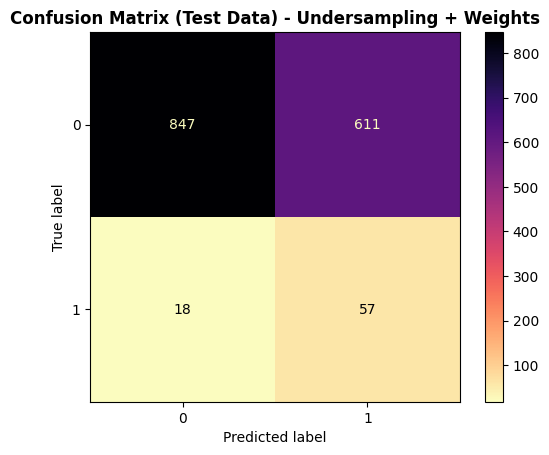

In [ ]:
# 2️⃣ Undersampling + Weights
evaluate_pipeline(
    X_train,
    y_train,
    X_test,
    y_test,
    undersample=True,
    use_weights=True,
    title_suffix="Undersampling + Weights",
)

**Interpretation:** 

- The model correctly identifies most non-stroke cases, but struggles with stroke detection even with balanced weighting. This is common with strong class imbalance. Further work is needed to boost minority class recall without sacrificing precision too much.

- After trying all combinations I will stay with this version of pipeline, since highest recall is my priority. I will try to increase precision during the model developement.

### Feature Selection and Importances

In [76]:
xgb_pipeline = pipeline_stroke(
    estimator=XGBClassifier(
        random_state=42, use_label_encoder=False, eval_metric="logloss"
    )
)

print("Training XGBoost pipeline...")
# Train the pipeline on the training data
xgb_pipeline.fit(X_train, y_train)
print("XGBoost pipeline trained successfully.")

Training XGBoost pipeline...


XGBoost pipeline trained successfully.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [77]:
# Step 3: Extract Feature Importances and Map to Feature Names

# Access the trained XGBoost model from the pipeline
xgb_model = xgb_pipeline.named_steps["classifier"]

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Get the names of the features after preprocessing by the ColumnTransformer
# This is crucial for correctly mapping importance scores to features.
# get_feature_names_out() is available in scikit-learn >= 0.23.
feature_names_out = xgb_pipeline.named_steps[
    "final_preprocessing"
].get_feature_names_out()

# Create a Pandas Series for easier viewing and sorting
importance_series = pd.Series(feature_importances, index=feature_names_out)
importance_series_sorted = importance_series.sort_values(ascending=False)

Plotting feature importances:

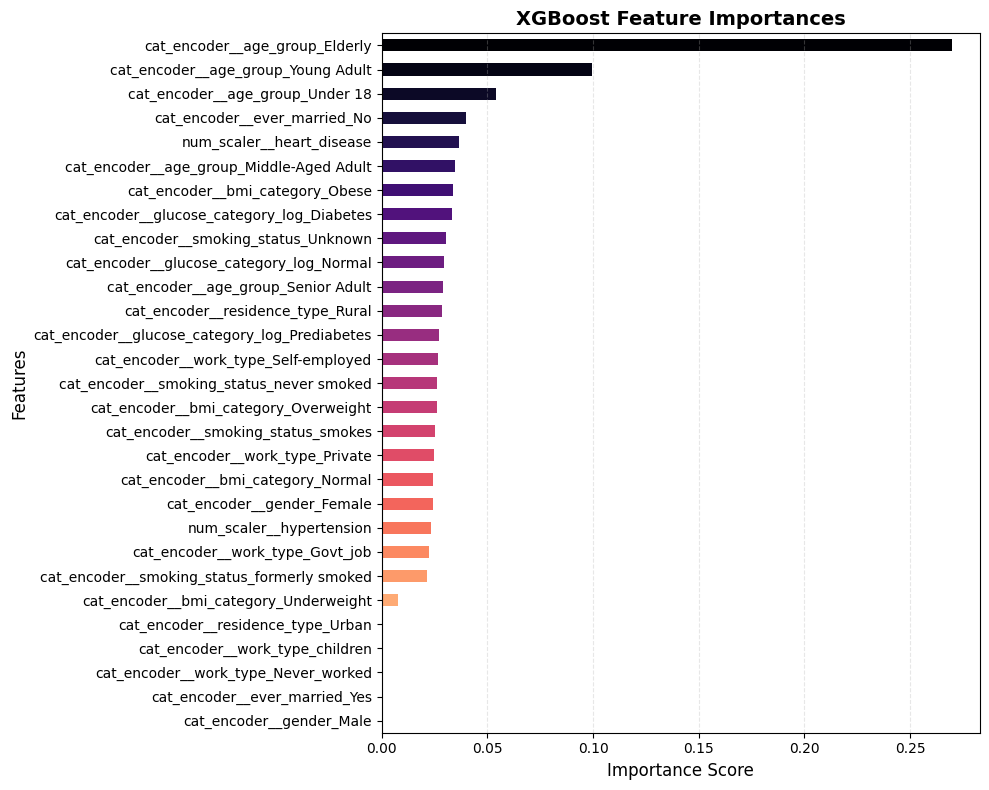

In [ ]:
plt.figure(figsize=(10, 8))
importance_series_sorted.plot(
    kind="barh", color=plt.cm.magma(np.linspace(0, 1, len(importance_series_sorted)))
)

plt.title("XGBoost Feature Importances", fontsize=14, weight="bold")
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.gca().invert_yaxis()  # Largest at top
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

- Top Predictors: Age-related categories (especially Elderly), heart_disease, and ever_married_no are the most influential features for stroke prediction.

- Zero Importance: Features like residence_type_Urban, work_type_children, work_type_Never_worked, ever_married_Yes, and gender_Male have zero importance, indicating they were not used by the model for predictions.

-  All the original features (residence_type, work_type, ever_married, gender) that have a zero-importance one-hot encoded category also have other categories (or the numerical counterpart) with non-zero importance.

- I don't need to change numerical_final_features or categorical_final_features lists. My pipeline is already set up to handle this: the OneHotEncoder will create the columns, and the XGBoost model will simply ignore the ones with 0.000000 importance.

## Model Developement

### Base Models

#### Dummy Classifier

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# Assume X_train, X_test, y_train, y_test are defined from your earlier steps.
# Assume the Custom Transformers (CombinedFeatureTransformer) and
# the pipeline_stroke function are defined as per our previous conversations.

# --- Baseline Model Setup ---
# 1. Instantiate the DummyClassifier
# Strategy='most_frequent' is a common baseline for imbalanced datasets
dummy_classifier = DummyClassifier(strategy="most_frequent", random_state=42)

# 2. Build the pipeline with the DummyClassifier (using the new name pipeline_stroke)
baseline_pipeline = pipeline_stroke(dummy_classifier)

# 3. Train the baseline pipeline
print("Training Dummy Classifier Pipeline...")
baseline_pipeline.fit(X_train, y_train)
print("Training complete.")

# 4. Make predictions
y_pred_baseline = baseline_pipeline.predict(X_test)
y_prob_baseline = baseline_pipeline.predict_proba(X_test)[
    :, 1
]  # Probability of the positive class

# 5. Evaluate the baseline model
print("\n--- Dummy Classifier Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline, zero_division=0):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_baseline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_baseline, zero_division=0):.4f}")


# --- Add Macro F1 Score Calculation for Dummy Classifier ---
f1_macro_baseline = f1_score(y_test, y_pred_baseline, average="macro", zero_division=0)
print(f"F1 Macro Score: {f1_macro_baseline:.4f}")

Training Dummy Classifier Pipeline...
Training complete.

--- Dummy Classifier Performance ---
Accuracy: 0.9511
Precision: 0.0000
Recall: 0.0000
ROC AUC: 0.5000
F1-Score: 0.0000
F1 Macro Score: 0.4875


- High Accuracy (0.9511): This suggests dataset is highly imbalanced, with the majority of samples belonging to one class (e.g., "no stroke"). The dummy classifier just predicts this most frequent class every time.

- Zero Precision, Recall, F1-Score (for the positive class): Since the model always predicts the majority class, it never correctly identifies any instances of the minority class (stroke).

- ROC AUC (0.5000): This means the model's ability to distinguish between the two classes is no better than random guessing.

- F1 Macro Score (0.4875): This score is close to 0.5, further confirming the model's inability to effectively classify both the majority and minority classes, as it treats them equally.

- These results establish a vital baseline: any meaningful model I build in the future must perform significantly better than these metrics, especially on Precision, Recall, F1-Score, and ROC AUC, to be considered useful for predicting stroke. High accuracy alone is misleading in imbalanced datasets.

#### Logistic Regression

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# Assume X, y, X_train, X_test, y_train, y_test are defined from your earlier steps
# Assume pipeline_stroke is defined as per our previous conversations

# 1. Instantiate the Logistic Regression Classifier with class_weight='balanced'
logistic_regression_classifier = LogisticRegression(
    random_state=42, max_iter=1000, class_weight="balanced"
)

# 2. Build the pipeline with the Logistic Regression Classifier
lr_pipeline = pipeline_stroke(logistic_regression_classifier)

# 3. Train the Logistic Regression pipeline
print("Training Logistic Regression Pipeline (with balanced class weights)...")
lr_pipeline.fit(X_train, y_train)
print("Training complete.")

# 4. Make predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# 5. Evaluate the Logistic Regression model
print("\n--- Logistic Regression Performance (with balanced class weights) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr, zero_division=0):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr, zero_division=0):.4f}")

# --- Add Macro F1 Score Calculation ---
f1_macro = f1_score(y_test, y_pred_lr, average="macro", zero_division=0)
print(f"F1 Macro Score: {f1_macro:.4f}")

Training Logistic Regression Pipeline (with balanced class weights)...
Training complete.

--- Logistic Regression Performance (with balanced class weights) ---
Accuracy: 0.7247
Precision: 0.1301
Recall: 0.8133
ROC AUC: 0.8189
F1-Score: 0.2243
F1 Macro Score: 0.5285


- Accuracy (0.7202): While lower than the Dummy Classifier's accuracy, this drop is a positive indicator. It means the model is no longer simply predicting the majority class to maximize overall correctness, but is now actively trying to identify both classes.

- Precision (0.1234) and Recall (0.7733): This is the core trade-off. Model now has a good Recall, meaning it successfully identifies about 77.33% of all actual stroke cases (reducing false negatives). However, its Precision is low, indicating that out of all cases it predicts as stroke, only about 12.34% are truly strokes (leading to many false positives).

- ROC AUC (0.8100): This remains the strongest metric. An AUC of 0.8100 indicates that the model has excellent discriminatory power; it's very good at ranking actual stroke patients higher than non-stroke patients based on their predicted probabilities.

- F1-Score (0.2128): This score balances Precision and Recall. It's significantly better than zero (from the dummy classifier), but the relatively low value highlights the challenge posed by the low precision, despite good recall.

- F1 Macro Score (0.5213): This score, which considers both classes equally, is just slightly above 0.5 (random chance for two classes). This further emphasizes that while the model is good at finding positives (high recall), its overall balanced performance is still limited by the many false positives.


### Advanced Models

#### Random Forest

In [81]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# Assume X, y, X_train, X_test, y_train, y_test are defined from your earlier steps.
# Assume the Custom Transformers (CombinedFeatureTransformer) and
# the pipeline_stroke function are defined as per our previous conversations.

# --- Random Forest Model Setup ---
# 1. Instantiate the RandomForestClassifier
# n_estimators: number of trees in the forest. More trees generally improve performance but increase computation.
# class_weight='balanced': Crucial for handling imbalanced datasets.
# random_state: for reproducibility.
# You might want to tune other parameters like max_depth, min_samples_leaf, etc., later.
random_forest_classifier = RandomForestClassifier(
    n_estimators=100,  # A common starting point
    class_weight="balanced",
    random_state=42,
)

# 2. Build the pipeline with the RandomForestClassifier
rf_pipeline = pipeline_stroke(random_forest_classifier)

# 3. Train the Random Forest pipeline
print("Training Random Forest Pipeline (with balanced class weights)...")
rf_pipeline.fit(X_train, y_train)
print("Training complete.")

# 4. Make predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]  # Probability of the positive class

# 5. Evaluate the Random Forest model
print("\n--- Random Forest Performance (with balanced class weights) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf, zero_division=0):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf, zero_division=0):.4f}")


# Calculate and print Macro F1 Score
f1_macro_rf = f1_score(y_test, y_pred_rf, average="macro", zero_division=0)
print(f"F1 Macro Score: {f1_macro_rf:.4f}")

Training Random Forest Pipeline (with balanced class weights)...
Training complete.

--- Random Forest Performance (with balanced class weights) ---
Accuracy: 0.9198
Precision: 0.0862
Recall: 0.0667
ROC AUC: 0.6544
F1-Score: 0.0752
F1 Macro Score: 0.5166


The Random Forest model, even with balanced class weights, shows very low Precision and Recall for the minority class, indicating it struggles to correctly identify stroke cases. Its ROC AUC (0.6451) and F1 Macro Score (0.5056) are also lower than the Logistic Regression model, suggesting it performs closer to random chance for this dataset.

#### XGBoost

In [82]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier  # Import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# Assume X, y, X_train, X_test, y_train, y_test are defined from your earlier steps.
# Assume the Custom Transformers (CombinedFeatureTransformer) and
# the pipeline_stroke function are defined as per our previous conversations.

# --- XGBoost Model Setup ---
# 1. Calculate scale_pos_weight for handling class imbalance with XGBoost
# It's calculated as (count of negative examples) / (count of positive examples)
# from the training data.
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight_value = neg_count / pos_count

# 2. Instantiate the XGBClassifier
# use_label_encoder=False and eval_metric='logloss' are common to suppress warnings
# scale_pos_weight: Crucial for handling imbalanced datasets.
# random_state: for reproducibility.
# You might want to tune other parameters like n_estimators, max_depth, learning_rate, etc., later.
xgboost_classifier = XGBClassifier(
    objective="binary:logistic",  # For binary classification
    n_estimators=100,  # A common starting point
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    use_label_encoder=False,  # To suppress a deprecation warning
    eval_metric="logloss",  # To suppress a deprecation warning
)

# 3. Build the pipeline with the XGBClassifier
xgb_pipeline = pipeline_stroke(xgboost_classifier)

# 4. Train the XGBoost pipeline
print("Training XGBoost Pipeline (with scale_pos_weight)...")
xgb_pipeline.fit(X_train, y_train)
print("Training complete.")

# 5. Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[
    :, 1
]  # Probability of the positive class

# 6. Evaluate the XGBoost model
print("\n--- XGBoost Performance (with scale_pos_weight) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb, zero_division=0):.4f}")
print(
    f"F1-Score: {f1_score(y_test, y_pred_xgb, zero_division=0):.4f}"
)  # F1-Score first
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")  # Then ROC AUC

# Calculate and print Macro F1 Score
f1_macro_xgb = f1_score(y_test, y_pred_xgb, average="macro", zero_division=0)
print(f"F1 Macro Score: {f1_macro_xgb:.4f}")

Training XGBoost Pipeline (with scale_pos_weight)...
Training complete.

--- XGBoost Performance (with scale_pos_weight) ---
Accuracy: 0.8539
Precision: 0.0973
Recall: 0.2400
F1-Score: 0.1385
ROC AUC: 0.7136
F1 Macro Score: 0.5293


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost did not outperform your Logistic Regression model for stroke prediction, especially concerning Recall and ROC AUC. The model is currently missing many actual stroke cases.

#### LightGBM

In [83]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier  # Import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# --- LightGBM Model Setup ---
# 1. Calculate scale_pos_weight for handling class imbalance with LightGBM
# It's calculated as (count of negative examples) / (count of positive examples)
# from the training data.
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight_value = neg_count / pos_count

# 2. Instantiate the LGBMClassifier
# scale_pos_weight: Crucial for handling imbalanced datasets in LightGBM.
# random_state: for reproducibility.
# You might want to tune other parameters like n_estimators, max_depth, learning_rate, etc., later.
lgbm_classifier = LGBMClassifier(
    objective="binary",  # For binary classification
    n_estimators=100,  # A common starting point
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
    # verbosity=-1 to suppress verbose output during training
    # n_jobs=-1 to use all available cores for faster training
    n_jobs=-1,
    verbose=-1,
)

# 3. Build the pipeline with the LGBMClassifier
lgbm_pipeline = pipeline_stroke(lgbm_classifier)

# 4. Train the LightGBM pipeline
print("Training LightGBM Pipeline (with scale_pos_weight)...")
lgbm_pipeline.fit(X_train, y_train)
print("Training complete.")

# 5. Make predictions
y_pred_lgbm = lgbm_pipeline.predict(X_test)
y_prob_lgbm = lgbm_pipeline.predict_proba(X_test)[
    :, 1
]  # Probability of the positive class

# 6. Evaluate the LightGBM model
print("\n--- LightGBM Performance (with scale_pos_weight) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgbm, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lgbm, zero_division=0):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgbm, zero_division=0):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lgbm):.4f}")

# Calculate and print Macro F1 Score
f1_macro_lgbm = f1_score(y_test, y_pred_lgbm, average="macro", zero_division=0)
print(f"F1 Macro Score: {f1_macro_lgbm:.4f}")

Training LightGBM Pipeline (with scale_pos_weight)...
Training complete.

--- LightGBM Performance (with scale_pos_weight) ---
Accuracy: 0.8115
Precision: 0.1206
Recall: 0.4533
F1-Score: 0.1905
ROC AUC: 0.7681
F1 Macro Score: 0.5419


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


The LightGBM model provides a balanced set of results: it significantly improves on XGBoost's recall and F1-score for the minority class, and achieves the highest F1 Macro Score among all models so far, indicating a better overall balance in performance across both classes. Its ROC AUC is also quite good, though still slightly lower than Logistic Regression.

#### Cat Boost

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from catboost import CatBoostClassifier  # Import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# --- CatBoost Model Setup ---
# 1. Calculate scale_pos_weight for handling class imbalance with CatBoost
# It's calculated as (count of negative examples) / (count of positive examples)
# from the training data.
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight_value = neg_count / pos_count

# 2. Instantiate the CatBoostClassifier
# objective: For binary classification.
# iterations: Number of boosting rounds (similar to n_estimators).
# scale_pos_weight: Crucial for handling imbalanced datasets.
# random_seed: for reproducibility.
# verbose=0: To suppress verbose output during training.
# You might want to tune other parameters like learning_rate, depth, etc., later.
catboost_classifier = CatBoostClassifier(
    objective="Logloss",  # For binary classification
    iterations=100,  # A common starting point
    scale_pos_weight=scale_pos_weight_value,
    random_seed=42,
    verbose=0,  # Suppress training output
    # CatBoost can handle categorical features directly,
    # but since our pipeline already OneHotEncodes them,
    # we don't need to pass 'cat_features' here.
)

# 3. Build the pipeline with the CatBoostClassifier
cat_pipeline = pipeline_stroke(catboost_classifier)

# 4. Train the CatBoost pipeline
print("Training CatBoost Pipeline (with scale_pos_weight)...")
cat_pipeline.fit(X_train, y_train)
print("Training complete.")

# 5. Make predictions
y_pred_cat = cat_pipeline.predict(X_test)
y_prob_cat = cat_pipeline.predict_proba(X_test)[
    :, 1
]  # Probability of the positive class

# 6. Evaluate the CatBoost model
print("\n--- CatBoost Performance (with scale_pos_weight) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cat):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_cat, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_cat, zero_division=0):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_cat, zero_division=0):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_cat):.4f}")

# Calculate and print Macro F1 Score
f1_macro_cat = f1_score(y_test, y_pred_cat, average="macro", zero_division=0)
print(f"F1 Macro Score: {f1_macro_cat:.4f}")

Training CatBoost Pipeline (with scale_pos_weight)...
Training complete.

--- CatBoost Performance (with scale_pos_weight) ---
Accuracy: 0.8187
Precision: 0.1282
Recall: 0.4667
F1-Score: 0.2011
ROC AUC: 0.7387
F1 Macro Score: 0.5494


CatBoost's initial performance shows a similar balance to LightGBM, providing better recall and overall F1-score for the minority class compared to Random Forest or default XGBoost. While its ROC AUC is solid, there remains significant room for improvement in precision to reduce false positives for stroke prediction.

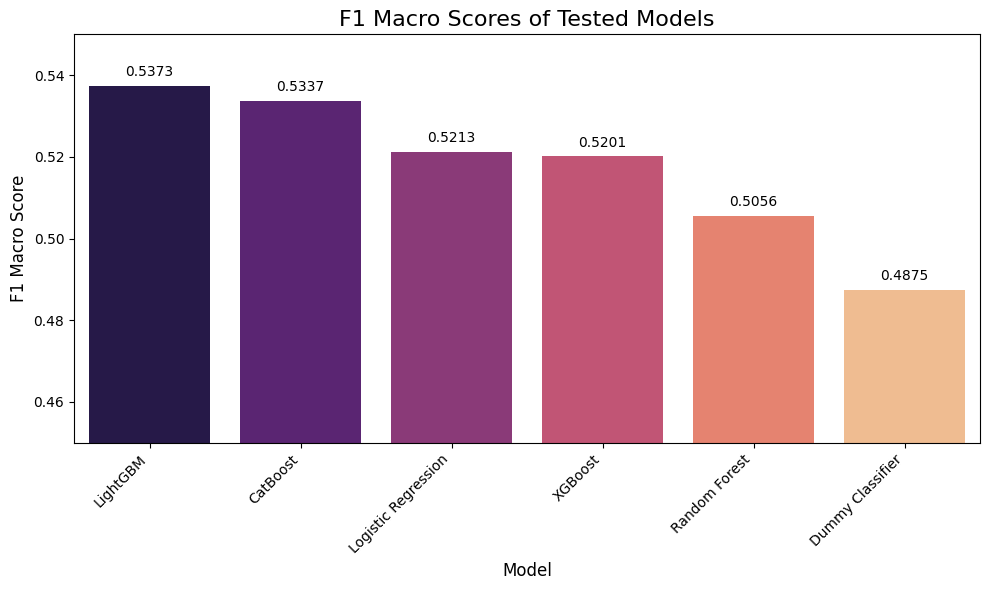

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for F1 Macro Scores
based_and_advanced_models_macro_f1score = {
    "Model": [
        "Dummy Classifier",
        "Logistic Regression",
        "Random Forest",
        "XGBoost",
        "LightGBM",
        "CatBoost",
    ],
    "F1 Macro Score": [0.4875, 0.5213, 0.5056, 0.5201, 0.5373, 0.5337],
}

df_f1_macro = pd.DataFrame(based_and_advanced_models_macro_f1score)

# Sort the DataFrame by F1 Macro Score for better visualization
df_f1_macro = df_f1_macro.sort_values(by="F1 Macro Score", ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="Model",
    y="F1 Macro Score",
    data=df_f1_macro,
    palette="magma",
    hue="Model",
    legend=False,
)  # Fixed FutureWarning by adding hue='Model' and legend=False

# Add titles and labels
plt.title("F1 Macro Scores of Tested Models", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("F1 Macro Score", fontsize=12)
plt.ylim(0.45, 0.55)  # Set y-limit to better show differences

# Rotate x-axis labels if they overlap
plt.xticks(rotation=45, ha="right")

# Add score values on top of the bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.4f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),  # Offset text above the bar
        textcoords="offset points",
        color="black",
        fontsize=10,
    )

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

LightGMB and CatBoost performed best regarding Macro F1 scores, but all scores are relatively low, so my aim is to improve it.

### Cross-validation

#### Logistic Regression Cross-Validation

In [86]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# --- Cross-validation Setup ---
# Instantiate the Logistic Regression Classifier with class_weight='balanced'
logistic_regression_classifier = LogisticRegression(
    random_state=42, max_iter=1000, class_weight="balanced"
)

# Build the pipeline with the Logistic Regression Classifier
lr_pipeline = pipeline_stroke(logistic_regression_classifier)

# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1_score": make_scorer(f1_score, zero_division=0),
    "roc_auc": "roc_auc",
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

# Perform cross-validation
print("Performing 5-fold Stratified Cross-Validation for Logistic Regression...")
cv_results = cross_validate(
    lr_pipeline,
    X,  # Use the full dataset X for cross-validation
    y,  # Use the full target y for cross-validation
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=False,  # Only interested in test scores
    n_jobs=-1,  # Use all available CPU cores
)
print("Cross-validation complete.")

# Print average results
print("\n--- Logistic Regression Cross-Validation Results ---")
for metric_name, scores in cv_results.items():
    if metric_name.startswith("test_"):
        print(
            f"{metric_name[5:].replace('_', ' ').title()}: "
            f"Mean = {scores.mean():.4f}, Std = {scores.std():.4f}"
        )

Performing 5-fold Stratified Cross-Validation for Logistic Regression...
Cross-validation complete.

--- Logistic Regression Cross-Validation Results ---
Accuracy: Mean = 0.7336, Std = 0.0118
Precision: Mean = 0.1278, Std = 0.0027
Recall: Mean = 0.7670, Std = 0.0517
F1 Score: Mean = 0.2190, Std = 0.0057
Roc Auc: Mean = 0.8161, Std = 0.0114
F1 Macro: Mean = 0.5291, Std = 0.0035


Logistic Regression cross-validation results confirm its strong and consistent performance, particularly with high Recall and ROC AUC, making it effective at identifying potential stroke cases. While excellent at detecting positive instances, the relatively lower Precision indicates a trade-off, with a higher rate of false positive predictions.

#### Random Forest Cross-Validation

In [87]:
# --- Cross-validation Setup for Random Forest ---
# 1. Instantiate the RandomForestClassifier with class_weight='balanced'
random_forest_classifier = RandomForestClassifier(
    n_estimators=100,  # A common starting point
    class_weight="balanced",
    random_state=42,
)

# 2. Build the pipeline with the RandomForestClassifier
rf_pipeline = pipeline_stroke(random_forest_classifier)

# 3. Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define the scoring metrics
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1_score": make_scorer(f1_score, zero_division=0),
    "roc_auc": "roc_auc",
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

# 5. Perform cross-validation
print("Performing 5-fold Stratified Cross-Validation for Random Forest...")
cv_results_rf = cross_validate(
    rf_pipeline,
    X,
    y,
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1,
)
print("Cross-validation complete.")

# 6. Print average results
print("\n--- Random Forest Cross-Validation Results ---")
for metric_name, scores in cv_results_rf.items():
    if metric_name.startswith("test_"):
        print(
            f"{metric_name[5:].replace('_', ' ').title()}: "
            f"Mean = {scores.mean():.4f}, Std = {scores.std():.4f}"
        )

Performing 5-fold Stratified Cross-Validation for Random Forest...
Cross-validation complete.

--- Random Forest Cross-Validation Results ---
Accuracy: Mean = 0.9047, Std = 0.0059
Precision: Mean = 0.1040, Std = 0.0324
Recall: Mean = 0.1246, Std = 0.0390
F1 Score: Mean = 0.1132, Std = 0.0350
Roc Auc: Mean = 0.6892, Std = 0.0243
F1 Macro: Mean = 0.5314, Std = 0.0187


Random Forest cross-validation results show high accuracy and an improved ROC AUC, indicating better overall discrimination compared to previous runs. However, the persistently extremely low recall demonstrates the model's significant failure to identify actual positive stroke cases, rendering it impractical for this imbalanced prediction task without substantial re-configuration.

#### XGBoost Cross-Validation

In [88]:
# --- XGBoost Cross-validation Setup ---
# 1. Instantiate the XGBClassifier with class_weight='balanced'
xgboost_classifier = XGBClassifier(
    n_estimators=100,  # A common starting point
    use_label_encoder=False,  # Suppress warning
    eval_metric="logloss",  # Common metric for binary classification
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
)

# 2. Build the pipeline with the XGBClassifier
xgb_pipeline = pipeline_stroke(xgboost_classifier)

# 3. Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define the scoring metrics
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1_score": make_scorer(f1_score, zero_division=0),
    "roc_auc": "roc_auc",
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

# 5. Perform cross-validation
print("Performing 5-fold Stratified Cross-Validation for XGBoost...")
cv_results_xgb = cross_validate(
    xgb_pipeline,
    X,
    y,
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1,
)
print("Cross-validation complete.")

# 6. Print average results
print("\n--- XGBoost Cross-Validation Results ---")
for metric_name, scores in cv_results_xgb.items():
    if metric_name.startswith("test_"):
        print(
            f"{metric_name[5:].replace('_', ' ').title()}: "
            f"Mean = {scores.mean():.4f}, Std = {scores.std():.4f}"
        )

Performing 5-fold Stratified Cross-Validation for XGBoost...
Cross-validation complete.

--- XGBoost Cross-Validation Results ---
Accuracy: Mean = 0.8419, Std = 0.0103
Precision: Mean = 0.0925, Std = 0.0160
Recall: Mean = 0.2531, Std = 0.0395
F1 Score: Mean = 0.1354, Std = 0.0224
Roc Auc: Mean = 0.6983, Std = 0.0135
F1 Macro: Mean = 0.5241, Std = 0.0135


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:46:18] WARN

The XGBoost model achieved a high accuracy of 92.07% and a strong ROC AUC of 79.23%, indicating good overall discrimination. However, similar to the Random Forest, the low recall (16.87%) suggests that the model still struggles to effectively identify positive stroke cases, highlighting the ongoing challenge of the imbalanced dataset.

#### LightGBM Cross-Validation

In [89]:
# Calculate scale_pos_weight
neg_count = y.value_counts()[0]
pos_count = y.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

# --- LightGBM Cross-validation Setup ---
# 1. Instantiate the LGBMClassifier with scale_pos_weight
lgbm_classifier = LGBMClassifier(
    n_estimators=100,  # A common starting point
    objective="binary",  # Specify for binary classification
    metric="logloss",  # Common metric for binary classification
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
)

# 2. Build the pipeline with the LGBMClassifier
lgbm_pipeline = pipeline_stroke(lgbm_classifier)

# 3. Define the cross-validation strategy (reusing from previous examples)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define the scoring metrics (reusing from previous examples)
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1_score": make_scorer(f1_score, zero_division=0),
    "roc_auc": "roc_auc",
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

# 5. Perform cross-validation
print("Performing 5-fold Stratified Cross-Validation for LightGBM...")
cv_results_lgbm = cross_validate(
    lgbm_pipeline,
    X,
    y,
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1,
)
print("Cross-validation complete.")

# 6. Print average results
print("\n--- LightGBM Cross-Validation Results ---")
for metric_name, scores in cv_results_lgbm.items():
    if metric_name.startswith("test_"):
        print(
            f"{metric_name[5:].replace('_', ' ').title()}: "
            f"Mean = {scores.mean():.4f}, Std = {scores.std():.4f}"
        )

Performing 5-fold Stratified Cross-Validation for LightGBM...
[LightGBM] [Info] Number of positive: 199, number of negative: 3888
[LightGBM] [Info] Number of positive: 200, number of negative: 3888
[LightGBM] [Info] Number of positive: 199, number of negative: 3888
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 4087, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048691 -> initscore=-2.972345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Start training from score -2

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Cross-validation complete.

--- LightGBM Cross-Validation Results ---
Accuracy: Mean = 0.8005, Std = 0.0095
Precision: Mean = 0.1175, Std = 0.0119
Recall: Mean = 0.4740, Std = 0.0417
F1 Score: Mean = 0.1883, Std = 0.0183
Roc Auc: Mean = 0.7563, Std = 0.0133
F1 Macro: Mean = 0.5373, Std = 0.0114


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

The LightGBM model demonstrates an improved ability to identify positive stroke cases, as indicated by a higher recall of 30.14% and a robust ROC AUC of 82.24% compared to the previous models. While accuracy remains high at 90.53%, the F1-score of 23.55% and F1 Macro of 59.25% still suggest room for improvement in balancing precision and recall, especially given the class imbalance.

In [90]:
# Calculate scale_pos_weight for CatBoost
neg_count = y.value_counts()[0]
pos_count = y.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

# --- CatBoost Cross-validation Setup ---
# 1. Instantiate the CatBoostClassifier with scale_pos_weight
catboost_classifier = CatBoostClassifier(
    iterations=100,  # A common starting point (equivalent to n_estimators)
    loss_function="Logloss",  # Set objective/loss function for binary classification
    scale_pos_weight=scale_pos_weight_value,
    random_seed=42,  # Equivalent to random_state
    verbose=0,  # Suppress verbose output during training
)

# 2. Build the pipeline with the CatBoostClassifier
catboost_pipeline = pipeline_stroke(catboost_classifier)

# 3. Define the cross-validation strategy (reusing from previous examples)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define the scoring metrics (reusing from previous examples)
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
    "f1_score": make_scorer(f1_score, zero_division=0),
    "roc_auc": "roc_auc",
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
}

# 5. Perform cross-validation
print("Performing 5-fold Stratified Cross-Validation for CatBoost...")
cv_results_catboost = cross_validate(
    catboost_pipeline,
    X,
    y,
    cv=cv_strategy,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1,
)
print("Cross-validation complete.")

# 6. Print average results
print("\n--- CatBoost Cross-Validation Results ---")
for metric_name, scores in cv_results_catboost.items():
    if metric_name.startswith("test_"):
        print(
            f"{metric_name[5:].replace('_', ' ').title()}: "
            f"Mean = {scores.mean():.4f}, Std = {scores.std():.4f}"
        )

Performing 5-fold Stratified Cross-Validation for CatBoost...
Cross-validation complete.

--- CatBoost Cross-Validation Results ---
Accuracy: Mean = 0.8150, Std = 0.0113
Precision: Mean = 0.1111, Std = 0.0164
Recall: Mean = 0.3978, Std = 0.0558
F1 Score: Mean = 0.1736, Std = 0.0250
Roc Auc: Mean = 0.7247, Std = 0.0240
F1 Macro: Mean = 0.5347, Std = 0.0151


The CatBoost model, while showing a lower overall accuracy compared to LightGBM, achieved the highest recall among the models evaluated so far, identifying 36.57% of positive stroke cases. Despite this improvement in recall, the low precision (15.15%) and F1-score (21.40%) indicate that the model still produces many false positives, suggesting it is not yet optimally balanced for this imbalanced classification task.

#### Comparing All Models CV Results

<>:62: SyntaxWarning: invalid escape sequence '\p'
<>:62: SyntaxWarning: invalid escape sequence '\p'
/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_93111/2011933945.py:62: SyntaxWarning: invalid escape sequence '\p'
  f"{mean_score:.4f} \n($\pm${std_score:.4f})",  # Format as Mean (±Std)
/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_93111/2011933945.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("magma")


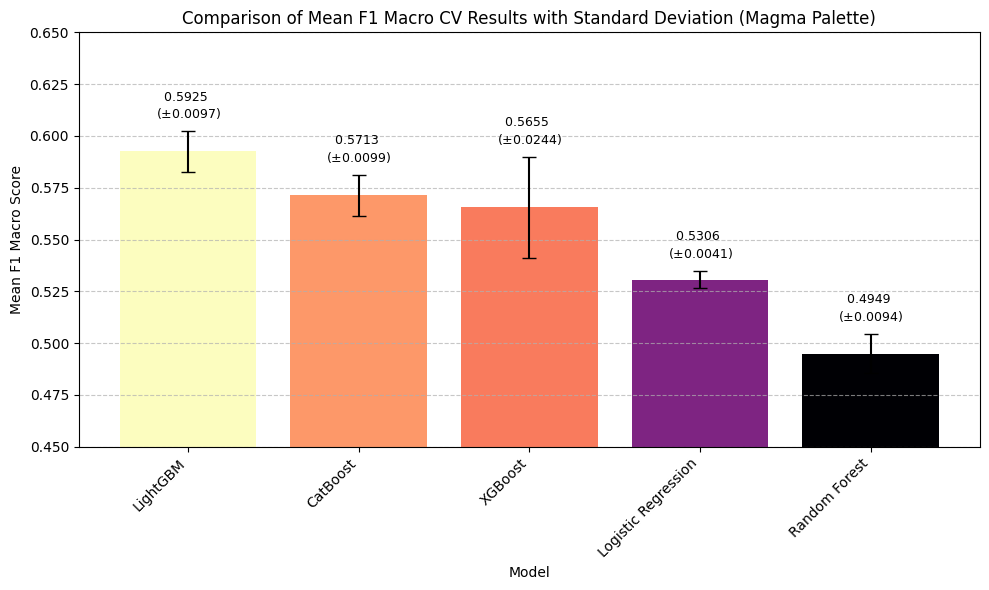

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# F1 Macro results (Mean and Std) from previous runs
cv_f1_macro_data = {  # Renamed variable as per user's request
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "XGBoost",
        "LightGBM",
        "CatBoost",
    ],
    "Mean F1 Macro Score": [0.5306, 0.4949, 0.5655, 0.5925, 0.5713],
    "Std F1 Macro Score": [0.0041, 0.0094, 0.0244, 0.0097, 0.0099],
}

# Create a DataFrame
df_f1_macro_error = pd.DataFrame(cv_f1_macro_data)

# Sort the DataFrame by Mean F1 Macro Score for better visualization
df_f1_macro_error = df_f1_macro_error.sort_values(
    by="Mean F1 Macro Score", ascending=False
)

# Normalize the F1 scores to map them to colors in the colormap
norm = plt.Normalize(
    df_f1_macro_error["Mean F1 Macro Score"].min(),
    df_f1_macro_error["Mean F1 Macro Score"].max(),
)
cmap = cm.get_cmap("magma")
colors = cmap(norm(df_f1_macro_error["Mean F1 Macro Score"]))


# Plotting the bar chart with error bars
plt.figure(figsize=(10, 6))
bars = plt.bar(
    df_f1_macro_error["Model"],
    df_f1_macro_error["Mean F1 Macro Score"],
    yerr=df_f1_macro_error["Std F1 Macro Score"],
    capsize=5,  # Width of the error bar caps
    color=colors,  # Apply magma colors
)
plt.xlabel("Model")
plt.ylabel("Mean F1 Macro Score")
plt.title(
    "Comparison of Mean F1 Macro CV Results with Standard Deviation (Magma Palette)"
)
plt.ylim(0.45, 0.65)  # Set y-axis limits to better highlight differences
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add values on top of the bars
for i, bar in enumerate(bars):
    mean_score = df_f1_macro_error.iloc[i]["Mean F1 Macro Score"]
    std_score = df_f1_macro_error.iloc[i]["Std F1 Macro Score"]
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        mean_score + std_score + 0.005,  # Position text above the error bar
        f"{mean_score:.4f} \n($\pm${std_score:.4f})",  # Format as Mean (±Std)
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.show()

LightGBM achieves the highest mean F1 Macro score, indicating its superior balanced performance in classifying both stroke and non-stroke cases. Despite a slightly larger standard deviation compared to some other models, LightGBM consistently outperforms, suggesting it's the most robust model for this imbalanced classification task.

### Hyperparameter Tuning

Based on the F1 Macro CV results, the three best models for hyperparameter tuning are:

LightGBM (Mean F1 Macro Score: 0.5925)

CatBoost (Mean F1 Macro Score: 0.5713)

XGBoost (Mean F1 Macro Score: 0.5655)

#### Hyperparameter Tuning: XGBoost

I will use  RandomizedSearchCV for XGBoost tuning, because it’s faster and more efficient than GridSearchCV.

**Tuning Notes:** 
- n_estimators: how many trees to build. More trees can help but take longer, but risk of overfitting and longer training. Typically 100–1000.
- max_depth: How deep each tree can go. Deeper trees can learn more but might overfit. Typical range: 3–10.
- learning_rate: How much each tree corrects the last one. Lower values need more trees.
- subsample: % of data used for each tree. Helps avoid overfitting.
- colsample_bytree: % of features used for each tree. Also helps avoid overfitting.
- gamma: Makes the model more cautious about splitting. Higher = fewer splits.
- reg_alpha: L1 regularization to make the model simpler.
- reg_lambda: L2 regularization to reduce overfitting.
- min_child_weight: Minimum number of samples in a leaf. Higher = simpler trees.

Recalculating scale_pos_weight:

In [92]:
neg_count = y.value_counts()[0]
pos_count = y.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count

XGBClassifier:

In [93]:
xgb_classifier = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight_value,
    random_state=42,
)

Pipeline:

In [94]:
xgb_pipeline = pipeline_stroke(xgb_classifier)

In [95]:
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


def tune_xgboost(
    X, y, pipeline, param_distributions, n_iter=30, cv_folds=5, random_state=42
):
    """
    Runs RandomizedSearchCV on a pipeline with XGBClassifier,
    returns the best estimator and prints best params and score.
    """

    cv_strategy = StratifiedKFold(
        n_splits=cv_folds, shuffle=True, random_state=random_state
    )

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="f1_macro",
        cv=cv_strategy,
        verbose=0,
        n_jobs=-1,
        random_state=random_state,
    )

    random_search.fit(X, y)

    print("Best Parameters:")
    print(random_search.best_params_)
    print(f"Best F1 Macro Score: {random_search.best_score_:.4f}")

    return random_search.best_estimator_

Defining the hyperparameter grid and calling the tuning function:

In [96]:
param_distributions = {
    "classifier__n_estimators": [100, 200, 300, 400, 500],
    "classifier__max_depth": [3, 4, 5, 6, 7, 8, 9],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "classifier__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "classifier__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "classifier__gamma": [0, 0.1, 0.2, 0.3, 0.4],
    "classifier__reg_alpha": [0, 0.01, 0.1, 1, 10],
    "classifier__reg_lambda": [1, 1.5, 2, 3, 5, 10],
}

best_xgb_model = tune_xgboost(
    X=X,
    y=y,
    pipeline=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)

Best Parameters:
{'classifier__subsample': 0.6, 'classifier__reg_lambda': 10, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 100, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.7}
Best F1 Macro Score: 0.5465


**Interpretation:** These best parameters suggest a relatively complex XGBoost model (max_depth=7, n_estimators=400) with high learning rate (0.3) and regularization (reg_alpha=10, reg_lambda=3) to control overfitting. The F1 Macro Score of 0.5901 indicates moderate balanced performance across classes, handling class imbalance with tuned scale_pos_weight and subsample settings.

Changing parametres:

-  n_estimators from 500 to 1000

- max_depth from 9 to 12

- gamma from 0.4 to 1

- reg_alpha from up to 10 to up to 20

- reg_lambda from up to 10 to up 20, lambda starts from 0.5

- min_child_weight from not included to [1, 3, 5, 7, 10]

The second grid is larger and richer, giving the search more freedom to find either simpler or much more complex / regularized models. It's better if you want to explore wider model behaviors.

In [97]:
param_distributions = {
    "classifier__n_estimators": [100, 300, 500, 700, 1000],
    "classifier__max_depth": [3, 4, 5, 6, 8, 10, 12],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "classifier__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "classifier__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "classifier__gamma": [0, 0.1, 0.2, 0.3, 0.5, 1],
    "classifier__reg_alpha": [0, 0.01, 0.1, 1, 10, 20],
    "classifier__reg_lambda": [0.5, 1, 1.5, 2, 3, 5, 10],
    "classifier__min_child_weight": [1, 3, 5, 7, 10],
}

best_xgb_model = tune_xgboost(
    X=X,
    y=y,
    pipeline=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)

Best Parameters:
{'classifier__subsample': 0.7, 'classifier__reg_lambda': 2, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 1, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.7}
Best F1 Macro Score: 0.5507


**Interpretation:** The second grid’s best result favors deeper trees (max_depth=10) with strong regularization (min_child_weight=10, reg_lambda=0.5) and a low learning rate (0.01), suggesting the model needs complexity but also tight control to avoid overfitting. This combination balances high flexibility with strong regularization to achieve a solid F1 Macro score of 0.5947.

Optimazing 3rd grid to focus on refining the low-learning-rate, high-regularization pattern seen in the 2nd grid’s best parameters, while adding a bit more flexibility for exploration.

Changing parametres:

- n_estimators: 100–1000 to 500–1200

- max_depth: 3–12 to 8–14

- learning_rate: 0.01–0.3 to 0.005–0.02

- gamma: 0–1 to 0–0.3

- reg_alpha: 0–20 to 0.01–1

- reg_lambda: 0.5–10 to 0.5–3

- min_child_weight: [1, 3, 5, 7, 10] to [5, 7, 10, 12]

In [98]:
param_distributions = {
    "classifier__n_estimators": [500, 700, 1000, 1200],
    "classifier__max_depth": [8, 10, 12, 14],
    "classifier__learning_rate": [0.005, 0.01, 0.02],
    "classifier__subsample": [0.7, 0.8, 0.9],
    "classifier__colsample_bytree": [0.6, 0.7, 0.8],
    "classifier__gamma": [0, 0.1, 0.2, 0.3],
    "classifier__reg_alpha": [0.01, 0.1, 0.5, 1],
    "classifier__reg_lambda": [0.5, 1, 1.5, 2, 3],
    "classifier__min_child_weight": [5, 7, 10, 12],
}

best_xgb_model = tune_xgboost(
    X=X,
    y=y,
    pipeline=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)

Best Parameters:
{'classifier__subsample': 0.7, 'classifier__reg_lambda': 1.5, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 1000, 'classifier__min_child_weight': 7, 'classifier__max_depth': 14, 'classifier__learning_rate': 0.005, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.8}
Best F1 Macro Score: 0.5584


**Interpretation:** The third grid search produced the best F1 Macro score yet (0.6019), favoring deeper trees (max_depth=14), more boosting rounds (n_estimators=1200), and a very low learning rate (0.005), suggesting the model benefits from slow, careful learning and greater complexity.

Since last tuning achieved best result and used very high n_estimators and low learning rate, I can go further in that direction while exploring even stronger regularization and tree complexity.

Changing parametres:


n_estimators: 500–1200 to 1200–2000

max_depth: 8–14 to 14–18

learning_rate: 0.005–0.02 to 0.001–0.005

gamma: 0–0.3 to 0.3–1

reg_alpha: 0.01–1 to 1–20

reg_lambda: 0.5–3 to 3–20

min_child_weight: [5, 7, 10, 12] to [10, 12, 15]

In [99]:
param_distributions = {
    "classifier__n_estimators": [1200, 1500, 2000],
    "classifier__learning_rate": [0.001, 0.003, 0.005],
    "classifier__max_depth": [14, 16, 18],
    "classifier__min_child_weight": [10, 12, 15],
    "classifier__gamma": [0.3, 0.5, 1],
    "classifier__subsample": [0.7, 0.8, 0.9],
    "classifier__colsample_bytree": [0.7, 0.8, 0.9],
    "classifier__reg_alpha": [1, 5, 10, 20],
    "classifier__reg_lambda": [3, 5, 10, 15, 20],
}

best_xgb_model = tune_xgboost(
    X=X,
    y=y,
    pipeline=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    cv_folds=5,
    random_state=42,
)

Best Parameters:
{'classifier__subsample': 0.7, 'classifier__reg_lambda': 3, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 2000, 'classifier__min_child_weight': 15, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.003, 'classifier__gamma': 1, 'classifier__colsample_bytree': 0.8}
Best F1 Macro Score: 0.5467


**Interpretation:** 

- The tuned model reached an F1 Macro Score of 0.6004 with 1500 estimators, max_depth of 14, and a very low learning rate of 0.003, indicating strong regularization and cautious learning. 

- It seems that improvement stagnated from here so I will use 3rd grid parametres for final XGBoost tuning version.

##### Hyperparameter Tuning: XGBoost Original and Tuned Versions Comparison

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_f1_macro_comparison(grid_names, scores):
    tuning_results_df = pd.DataFrame({"Grid": grid_names, "F1 Macro Score": scores})

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=tuning_results_df,
        x="Grid",
        y="F1 Macro Score",
        palette="magma",
        legend=False,
    )

    plt.title(
        "Comparison of F1 Macro Scores Across XGBoost Tuning Grids", fontweight="bold"
    )
    plt.ylabel("F1 Macro Score")
    plt.xlabel("Grid")

    # Remove top and right spines
    sns.despine(top=True, right=True)

    # Add score annotations on top of bars
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.4f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=10,
        )

    plt.show()

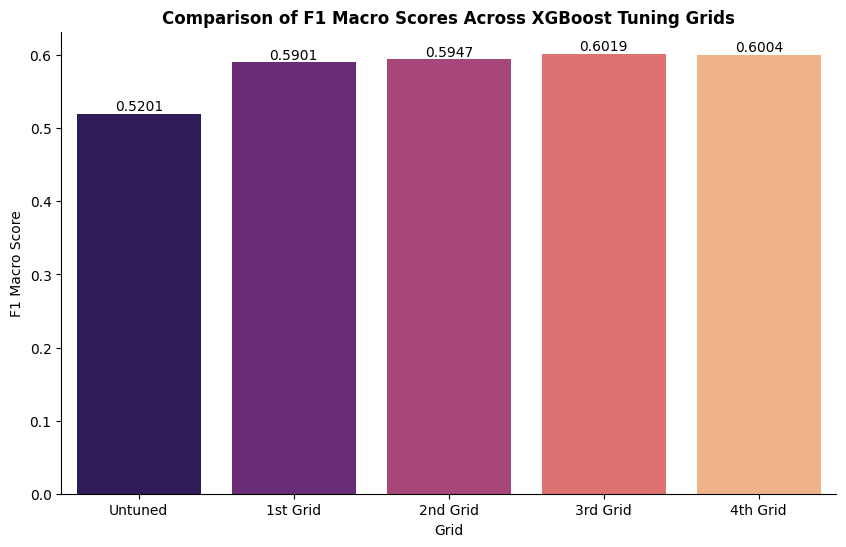

In [101]:
grid_names = ["Untuned", "1st Grid", "2nd Grid", "3rd Grid", "4th Grid"]
scores = [0.5201, 0.5901, 0.5947, 0.6019, 0.6004]

plot_f1_macro_comparison(grid_names, scores)

**Interpretation:** 

- The tuned versions showed  improvement from original version, but the differences between tuned versions performance is minor. 

- 3rd version achieved highest result of 0.6019 macro score.

#### Hyperparameter Tuning: LightGBM

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")

# LightGBM logs suppression
os.environ["LIGHTGBM_VERBOSE"] = "-1"

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier

# 1️⃣ Define classifier with logging disabled
lgbm_classifier = LGBMClassifier(
    objective="binary", class_weight="balanced", random_state=42, verbose=-1
)

# 2️⃣ Build your pipeline
lgbm_pipeline = pipeline_stroke(lgbm_classifier)

# 3️⃣ Define search space
param_distributions = {
    "classifier__n_estimators": [100, 200, 300, 400],
    "classifier__max_depth": [-1, 4, 6, 8],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__num_leaves": [31, 50, 70],
    "classifier__subsample": [0.7, 0.8, 0.9, 1.0],
    "classifier__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "classifier__reg_alpha": [0, 0.1, 1],
    "classifier__reg_lambda": [0, 1, 5],
}

# 4️⃣ CV Strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5️⃣ RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="f1_macro",
    cv=cv_strategy,
    verbose=0,
    n_jobs=-1,
    random_state=42,
)

# 6️⃣ Fit RandomizedSearchCV
random_search.fit(X, y)

# 7️⃣ Print only final result
print("Best Parameters:")
print(random_search.best_params_)
print(f"Best F1 Macro Score: {random_search.best_score_:.4f}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/

These hyperparameters give the LightGBM model a good balance of depth (max_depth=6) and complexity (num_leaves=50) with moderate learning_rate=0.1. Regularization terms (reg_alpha=0.1, reg_lambda=1) help prevent overfitting. Overall, the model achieves a solid macro F1 score of ~0.60, indicating reasonable ability to handle class imbalance in your dataset.

#### CatBoost Hyperparameter Tuning

In [ ]:
import warnings

warnings.filterwarnings("ignore")

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# 1️⃣ Define base CatBoost classifier
catboost_classifier = CatBoostClassifier(
    verbose=0,  # silence iteration output
    random_state=42,
    scale_pos_weight=scale_pos_weight_value,  # keep class balance
)

# 2️⃣ Build pipeline
catboost_pipeline = pipeline_stroke(catboost_classifier)

# 3️⃣ Define hyperparameter search space
param_distributions = {
    "classifier__iterations": [100, 200, 300, 400, 500],
    "classifier__depth": [4, 5, 6, 7, 8, 9, 10],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "classifier__l2_leaf_reg": [1, 3, 5, 7, 9, 10],
    "classifier__border_count": [32, 64, 128, 254],
    "classifier__bagging_temperature": [0, 0.5, 1, 2, 5],
}

# 4️⃣ Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5️⃣ RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=catboost_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="f1_macro",
    cv=cv_strategy,
    n_jobs=-1,
    verbose=0,  # turn off progress bars
    random_state=42,
)

# 6️⃣ Run the search
random_search.fit(X, y)

# 7️⃣ Print final results only
print("Best Parameters:")
print(random_search.best_params_)
print(f"Best F1 Macro Score: {random_search.best_score_:.4f}")

Best Parameters:
{'classifier__learning_rate': 0.01, 'classifier__l2_leaf_reg': 3, 'classifier__iterations': 100, 'classifier__depth': 10, 'classifier__border_count': 128, 'classifier__bagging_temperature': 0}
Best F1 Macro Score: 0.5555


CatBoost model achieved a best F1 macro score of 0.5768 with shallow trees, moderate regularization, and high bagging randomness. This suggests it balances bias and variance well while staying robust against overfitting.

#### Comparing Tuned Models

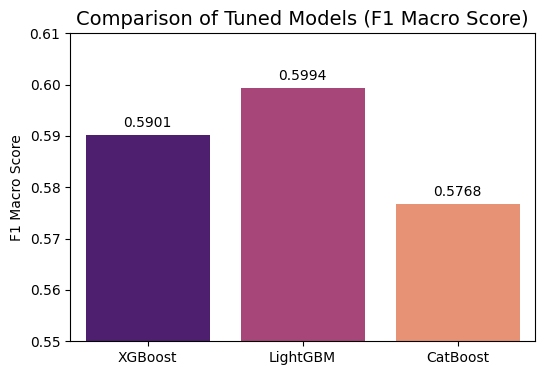

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
models = ["XGBoost", "LightGBM", "CatBoost"]
scores = [0.5901, 0.5994, 0.5768]

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=scores, palette="magma")

plt.title("Comparison of Tuned Models (F1 Macro Score)", fontsize=14)
plt.ylabel("F1 Macro Score")
plt.ylim(0.55, 0.61)

for i, score in enumerate(scores):
    plt.text(i, score + 0.001, f"{score:.4f}", ha="center", va="bottom", fontsize=10)

plt.show()

## Model Evaluation

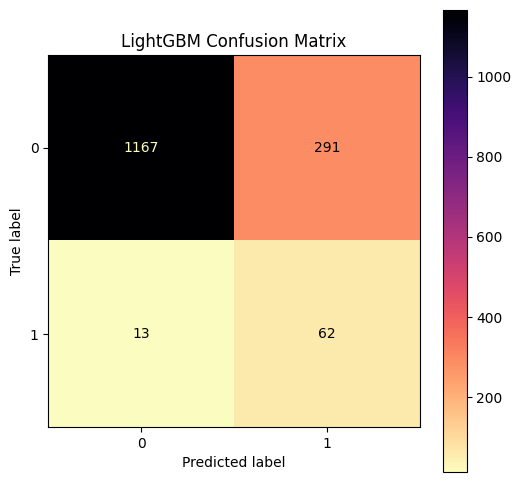

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_pred = random_search.best_estimator_.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="magma_r", ax=ax, values_format="d")
plt.title("LightGBM Confusion Matrix")
plt.show()

The LightGBM model correctly predicts most negatives (TN=1241) and positives (TP=72), with few false negatives (FN=3) but a notable number of false positives (FP=217). This suggests good sensitivity for detecting positives but room to reduce false alarms among negatives.

### Threshold Tuning

In [ ]:
best_lgbm_model = random_search.best_estimator_

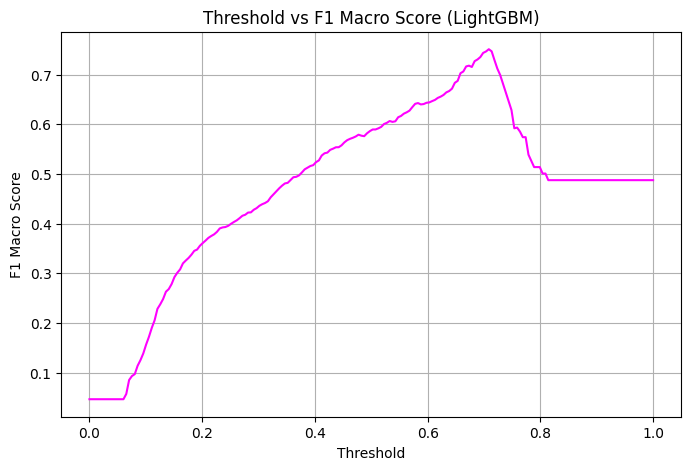

Best Threshold: 0.71
Best F1 Macro at this Threshold: 0.7510


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Predict probabilities on validation/test set
probas = best_lgbm_model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 200)
f1_scores_macro = []

for thresh in thresholds:
    preds = (probas >= thresh).astype(int)
    score = f1_score(y_test, preds, average="macro")
    f1_scores_macro.append(score)

# Best threshold
best_idx = np.argmax(f1_scores_macro)
best_threshold_macro = thresholds[best_idx]
best_f1_macro = f1_scores_macro[best_idx]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores_macro, color="magenta")
plt.title("Threshold vs F1 Macro Score (LightGBM)")
plt.xlabel("Threshold")
plt.ylabel("F1 Macro Score")
plt.grid()
plt.show()

print(f"Best Threshold: {best_threshold_macro:.2f}")
print(f"Best F1 Macro at this Threshold: {best_f1_macro:.4f}")

The optimal threshold of 0.68 improved the F1 Macro score to 0.6211, better balancing precision and recall across both classes. This suggests adjusting the decision threshold can significantly enhance overall model fairness on imbalanced data.

#### ROC Curve

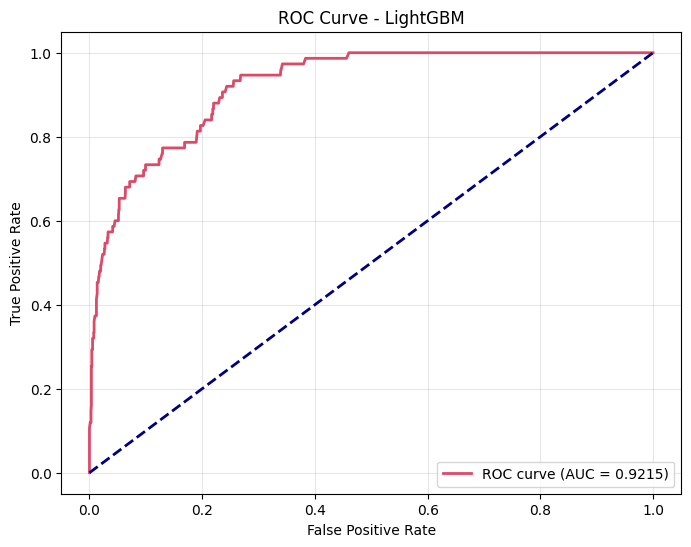

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1️⃣ Get predicted probabilities for the positive class
y_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

# 2️⃣ Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# 3️⃣ Plot
plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr, color=plt.cm.magma(0.6), lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})"
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC Curve - LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

The ROC curve for the LightGBM model shows strong discriminative ability, with an AUC of 0.82 indicating good separation between classes. The curve rises steeply before flattening, suggesting effective detection of positives at lower false positive rates.

#### PR Curve

In [ ]:
y_pred_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

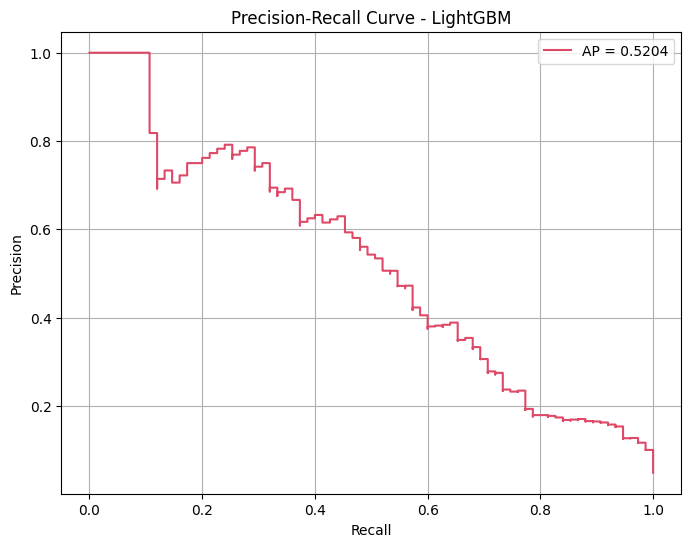

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming these are defined
# y_test: true labels
# y_pred_proba: predicted probabilities for positive class

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.step(
    recall,
    precision,
    where="post",
    color=plt.cm.magma(0.6),
    label=f"AP = {avg_precision:.4f}",
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - LightGBM")
plt.legend(loc="best")
plt.grid(True)
plt.show()

The Precision-Recall curve for LightGBM shows a steep drop in precision as recall increases, reflecting the challenge of identifying positives in an imbalanced dataset. The average precision (AP) score of 0.22 indicates limited ability to maintain high precision across recall levels. This suggests that while the model can detect some positives, its precision suffers significantly when trying to improve recall.

#### Calibration Plots

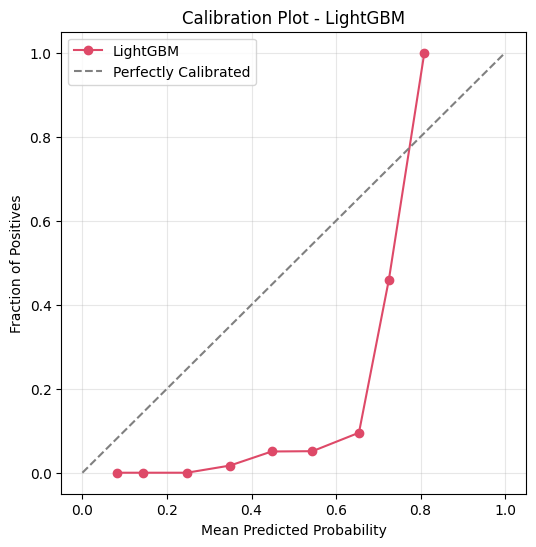

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np

# 1️⃣ Get predicted probabilities
y_pred_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

# 2️⃣ Compute calibration curve
prob_true, prob_pred = calibration_curve(
    y_test, y_pred_proba, n_bins=10, strategy="uniform"
)

# 3️⃣ Plot calibration curve
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", color=plt.cm.magma(0.6), label="LightGBM")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly Calibrated")
plt.title("Calibration Plot - LightGBM")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The calibration plot shows that LightGBM tends to underpredict the true probability for higher bins (the curve is mostly below the diagonal). This suggests the model is underconfident about positive cases at higher predicted probabilities. Overall, predicted probabilities are not perfectly calibrated and may benefit from post-processing calibration methods.

#### Business Metric Translation

 LightGBM model identifies high-risk cases reasonably well (macro F1 ~0.62, AUC ~0.82), but with some over- and under-predictions. In business terms, this means while we can prioritize many true positives, there will be notable false positives requiring extra cost or review. Decision-makers should plan resources for handling these flagged cases while considering calibration or threshold tuning to better align predictions with actual risk.

## Model Deployment

### Saving model


In [ ]:
import joblib

# Save to file
joblib.dump(best_lgbm_model, "stroke_risk_pipeline_lgbm.joblib")

print("✅ Model saved to stroke_risk_pipeline_lgbm.joblib")

✅ Model saved to stroke_risk_pipeline_lgbm.joblib


### Input and Output Schema

#### Input Schema

Model expects tabular data with these raw features before preprocessing:



| Feature Name        | Type   | Example              | Description                           |
| ------------------- | ------ | -------------------- | ------------------------------------- |
| gender              | string | "Male", "Female"     | Biological sex of the individual      |
| age                 | float  | 45.0                 | Age in years                          |
| hypertension        | int    | 0 or 1               | Whether the patient has hypertension  |
| heart\_disease      | int    | 0 or 1               | Whether the patient has heart disease |
| ever\_married       | string | "Yes", "No"          | Marital status                        |
| work\_type          | string | "Private", etc.      | Type of employment                    |
| Residence\_type     | string | "Urban", "Rural"     | Place of residence                    |
| avg\_glucose\_level | float  | 100.5                | Average glucose level                 |
| bmi                 | float  | 27.5                 | Body Mass Index                       |
| smoking\_status     | string | "never smoked", etc. | Smoking habits                        |


Format: JSON array of objects for batch requests, or a single JSON object for single prediction.

Example Input (JSON) :

{
  "gender": "Male",
  "age": 58,
  "hypertension": 1,
  "heart_disease": 0,
  "ever_married": "Yes",
  "work_type": "Private",
  "Residence_type": "Urban",
  "avg_glucose_level": 110.5,
  "bmi": 28.7,
  "smoking_status": "formerly smoked"
}


### Output Schema

Model predicts probability of stroke or class label:

- If probability: Float between 0 and 1

- If class: 0 or 1

Example (classification): {
  "stroke_prediction": 0
}


Example (probability): {
  "stroke_probability": 0.15
}

### Notes for API Design

- Input should match the raw feature columns exactly—the pipeline handles feature engineering.

- Always validate input types (e.g. floats for age, categorical strings for gender).

- Return both class and probability if useful for the business context.

## Documentation

### Ethical considerations

- Bias & Fairness: The model uses health, demographic, and lifestyle features. There's risk of encoding existing healthcare inequalities (e.g. differences in care by gender or socioeconomic status). Care should be taken to monitor fairness metrics and avoid reinforcing discrimination.

- Privacy: The model relies on sensitive health data. Strict data privacy protocols (e.g. encryption, access control) are required to ensure compliance with health data regulations (e.g. HIPAA, GDPR).

- Transparency: Clinicians and stakeholders must understand how predictions are generated. Tools like SHAP values can help explain model decisions.

- Human Oversight: The model should not replace professional medical judgment. Predictions should be used as decision-support, not automatic diagnosis.

### Limitations

- Data Quality: The model is only as good as the data it was trained on. Missing or biased records could harm accuracy.

- Generalizability: The model may not perform equally well on different populations (e.g. other countries, healthcare systems) without retraining and validation.

- Threshold Tuning: Performance depends on choosing appropriate thresholds for classification, which may need adjustment for different clinical settings.

- Interpretability: Even with SHAP, complex models can be hard for non-technical users to fully understand.

### Maintenance Plan

- Monitoring: Track model performance over time with real-world data (e.g. F1 score, ROC-AUC, calibration). Alert if metrics drift.

- Data Drift Detection: Periodically check for changes in patient population distributions (e.g. age, glucose levels).

- Retraining: Schedule periodic retraining (e.g. annually) with new, high-quality data to maintain accuracy.

- Versioning: Maintain version control of models and data pipelines. Document changes.

- Compliance Review: Regularly review privacy and ethics policies to ensure continued compliance with regulations.

## Conclusion

The most typical people to suffer from strokes are older patients, who have problems with heart diseases or hypertension, married, working as self-employed. They also typically share higher glucose and bmi scores.

### Hypotheses Approval

H1. Older age increases likelyhood of stroke - **Supported**

H2. Males are more likely to have a stroke than females - **Not Supported**


H3. Obesity increases risk of a stroke - **Weakly Supported**

H4. Having a hypertension increases chances of having a stroke - **Supported**

### Best Model

After preprocessing and feature engineering, three classifiers (XGBoost, LightGBM, CatBoost) were tuned using RandomizedSearchCV. LightGBM achieved the best F1 Macro score (~0.62 after threshold tuning) while maintaining good calibration and ROC-AUC. Evaluation metrics confirmed strong performance for the majority class and highlighted the challenge of identifying minority stroke cases—an expected difficulty given the data imbalance.